# Apresentação dos Dados

## Importação das bibliotecas necessárias

In [3]:
import fastf1
from fastf1 import plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter, MultipleLocator
import json

CACHE_DIR = './fastf1_cache'
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)
print(f"FastF1 cache enabled at: {os.path.abspath(CACHE_DIR)}")


BASE_PLOT_DIR = './f1_plots'
if not os.path.exists(BASE_PLOT_DIR):
    os.makedirs(BASE_PLOT_DIR)
print(f"Base directory for saving plots: {os.path.abspath(BASE_PLOT_DIR)}")

COMPOUND_COLORS = fastf1.plotting.COMPOUND_COLORS


FastF1 cache enabled at: c:\Users\mpoli\Desktop\UFOP\9 PERIODO\TCC\Scripts\fastf1_cache
Base directory for saving plots: c:\Users\mpoli\Desktop\UFOP\9 PERIODO\TCC\Scripts\f1_plots


C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


## 1. Coleta e Padronização de Dados Multitemporal

Nesta etapa, realizamos a extração automatizada dos dados de telemetria e cronometragem para o **Grande Prêmio do Bahrein** ao longo das temporadas da era híbrida recente (2022 a 2025). O objetivo é construir um *dataset* longitudinal que capture a evolução dos carros e das estratégias nesta pista específica.
A função itera sobre os anos definidos e utiliza a API `FastF1` para carregar os fluxos de dados essenciais.

### 🔧 Normalização de Compostos de Pneus (Mapeamento Físico)
Um desafio crítico na análise de dados da F1 é a nomenclatura relativa dos pneus. Os rótulos "Macio" (Soft), "Médio" (Medium) e "Duro" (Hard) mudam de dureza dependendo da pista e do ano. Para o Bahrein, não é o caso, mas isso ocorrerá em outras pistas que serão objetivo de estudo.

Para garantir que o modelo de Machine Learning aprenda a **física real da borracha** (degradação e aderência) e não apenas o rótulo do fim de semana, utilizamos um arquivo externo (`compounds.json`). Este arquivo mapeia os rótulos genéricos para os **Compostos Pirelli Reais (C1 a C6)**, criando a variável `pirelliCompound`. Isso permite que o modelo generalize o desgaste do pneu "C3" independentemente de ele ser chamado de "Macio" ou "Médio" em uma determinada corrida.

In [4]:
start_year_analysis = 2022
end_year_analysis = 2026
target_gp_name = 'Austrian Grand Prix'

all_results_data_by_year = {}
all_laps_data_by_year = {}
all_weather_data_by_year = {}
date = {}


print(f"\n--- Starting comprehensive data collection for {target_gp_name} from {start_year_analysis} to {end_year_analysis-1} ---")

for year in range(start_year_analysis, end_year_analysis):
    print(f"\n--- Collecting data for {target_gp_name} in Season: {year} ---")
    schedule = fastf1.get_event_schedule(year)
    target_event = schedule[schedule['EventName'].str.contains(target_gp_name, case=False, na=False)]

    if target_event.empty:
        print(f"  {target_gp_name} not found in {year} schedule, skipping.")
        continue
    
    target_race_round_row = target_event[target_event['EventFormat'].isin(['conventional', 'sprint', 'sprint_shootout', 'sprint_qualifying'])]
        
    if target_race_round_row.empty:
        print(f"  No 'conventional' or 'sprint' race event found for {target_gp_name} in {year}, skipping.")
        continue

    round_num = target_race_round_row['RoundNumber'].iloc[0]
    actual_event_name = target_race_round_row['EventName'].iloc[0] 

    print(f"  Found {actual_event_name} as Round {round_num} in {year}. Loading session...")

    session = fastf1.get_session(year, round_num, 'R') 
    session.load(laps=True, telemetry=True, weather=True, messages=True)

    laps_df = session.laps.copy()
    results_df = session.results.copy()
    
    if 'LapTime_seconds' not in laps_df.columns:
        laps_df['LapTime_seconds'] = laps_df['LapTime'].dt.total_seconds()

    race_name = session.event['EventName']
    json_path = 'compounds.json'
    with open(json_path, 'r') as file:
        compounds_data = json.load(file)
    
    year_str = str(year)
    
    if year_str in compounds_data['data']:
        compounds_for_year = compounds_data['data'][year_str]
        gp_compound_mapping = compounds_for_year.get(target_gp_name)

        if gp_compound_mapping:
            laps_df['pirelliCompound'] = laps_df['Compound'].map(gp_compound_mapping)
            
            laps_df['pirelliCompound'] = laps_df['pirelliCompound'].fillna(laps_df['Compound'])
            
            print(f" 'pirelliCompound' column created for {target_gp_name} {year}.")

        else:
            print(f" Warning: No compound mapping found in JSON for '{target_gp_name}' in year {year}. 'pirelliCompound' not created.")
    else:
        print(f" Warning: Year {year} not found in 'compounds.json'. 'pirelliCompound' not created.")
        laps_df['pirelliCompound'] = laps_df['Compound']

    all_results_data_by_year[year] = results_df
    all_laps_data_by_year[year] = laps_df
    all_weather_data_by_year[year] = session.weather_data
    date[year]= session.date
    
    print(f"Session data loaded for: {race_name} {year} Round {round_num}")
    print(f"Total laps: {len(laps_df)}, Total results: {len(results_df)}")



--- Starting comprehensive data collection for Austrian Grand Prix from 2022 to 2025 ---

--- Collecting data for Austrian Grand Prix in Season: 2022 ---


req         WARNING 	DEFAULT CACHE ENABLED! (7.96 GB) C:\Users\mpoli\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


  Found Austrian Grand Prix as Round 11 in 2022. Loading session...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 16 completed the race distance 00:00.024000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '44', '63', '31', '47', '4', '20', '3', '14', '77', '23', '18', '24', '10', '22', '5', '55', '6', '11']


 'pirelliCompound' column created for Austrian Grand Prix 2022.
Session data loaded for: Austrian Grand Prix 2022 Round 11
Total laps: 1324, Total results: 20

--- Collecting data for Austrian Grand Prix in Season: 2023 ---


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


  Found Austrian Grand Prix as Round 9 in 2023. Loading session...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '4', '14', '55', '63', '44', '18', '10', '23', '24', '2', '31', '77', '81', '21', '20', '22', '27']


 'pirelliCompound' column created for Austrian Grand Prix 2023.
Session data loaded for: Austrian Grand Prix 2023 Round 9
Total laps: 1354, Total results: 20

--- Collecting data for Austrian Grand Prix in Season: 2024 ---
  Found Austrian Grand Prix as Round 11 in 2024. Loading session...


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '81', '55', '44', '1', '27', '11', '20', '3', '10', '16', '31', '18', '22', '23', '77', '24', '14', '2', '4']


 'pirelliCompound' column created for Austrian Grand Prix 2024.
Session data loaded for: Austrian Grand Prix 2024 Round 11
Total laps: 1405, Total results: 20

--- Collecting data for Austrian Grand Prix in Season: 2025 ---
  Found Austrian Grand Prix as Round 11 in 2025. Loading session...


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '16', '44', '63', '30', '14', '5', '27', '31', '87', '6', '10', '18', '43', '22', '23', '1', '12', '55']


 'pirelliCompound' column created for Austrian Grand Prix 2025.
Session data loaded for: Austrian Grand Prix 2025 Round 11
Total laps: 1127, Total results: 20


## 2. Consolidação e Pré-Processamento do Dataset (Multi-Year)

Após a coleta individual por temporada, esta etapa realiza a **fusão dos dados** em um único *DataFrame* mestre. Isso é fundamental para que o modelo de Machine Learning tenha volume de dados suficiente para generalizar padrões, aprendendo não apenas com a corrida deste ano, mas com a evolução histórica da pista e dos carros.

### 🧹 Limpeza via Telemetria (`IsAccurate`)
Aplicamos aqui o primeiro e mais importante filtro de qualidade de dados fornecido pela API FastF1: a coluna `IsAccurate`.

Este filtro boolean remove automaticamente:
* Voltas de entrada e saída dos boxes (*In-laps* e *Out-laps*).
* Voltas realizadas sob regime de Safety Car ou VSC.
* Voltas onde a telemetria GPS falhou ou é inconsistente.

Ao manter apenas `clean_laps_df = combined_laps_df[combined_laps_df['IsAccurate'] == True]`, garantimos que o dataset contenha apenas voltas em **ritmo de corrida representativo**, eliminando ruídos grosseiros antes mesmo de iniciarmos a análise estatística detalhada.

In [5]:
print("Iniciando coleta de dados de múltiplos anos...")
lista_de_dataframes_anuais_laps = []
lista_de_dataframes_anuais_weather = []

for year in range(start_year_analysis, end_year_analysis):
    if year in all_laps_data_by_year:
        print(f"Carregando dados de {target_gp_name} {year}...")
        laps_df = all_laps_data_by_year[year]
        weather_df = all_weather_data_by_year[year]
        weather_df['Year'] = year
        laps_df['Year'] = year 
        
        lista_de_dataframes_anuais_laps.append(laps_df)
        lista_de_dataframes_anuais_weather.append(weather_df)
    else:
        print(f"Sem dados para {target_gp_name} {year}.")

if not lista_de_dataframes_anuais_laps:
    print("Nenhum dado encontrado para o intervalo de anos. Encerrando a análise.")
else:
    combined_laps_df = pd.concat(lista_de_dataframes_anuais_laps, ignore_index=True)
    print(f"\nDados de {len(lista_de_dataframes_anuais_laps)} anos combinados com sucesso!")
    print(f"Total de {len(combined_laps_df)} voltas carregadas.")
    # O isAccurate do FASTF1 diz se essa volta é uma volta válida, tirando voltas de voltas lentas (largada, SC, Pitstops, etc)
    clean_laps_df = combined_laps_df[combined_laps_df['IsAccurate'] == True].copy()
    clean_laps_df.dropna(subset=['LapTime_seconds', 'TyreLife', 'pirelliCompound'], inplace=True)

    print(f"Analisando {len(clean_laps_df)} voltas 'limpas' de todos os anos.")

    
    
    clean_laps_df['Year'] = clean_laps_df['Year'].astype('category')
    
    print(f"Total de {len(clean_laps_df)} voltas 'limpas' para análise.")

if not lista_de_dataframes_anuais_weather:
    print("Nenhum dado meteorológico encontrado para o intervalo de anos. Encerrando a análise.")
else:
    combined_weather_df = pd.concat(lista_de_dataframes_anuais_weather, ignore_index=True)
    print(f"Total de {len(combined_weather_df)} registros meteorológicos carregados.")
    print(f"\nDados de {len(lista_de_dataframes_anuais_weather)} anos combinados com sucesso!")
   

    

Iniciando coleta de dados de múltiplos anos...
Carregando dados de Austrian Grand Prix 2022...
Carregando dados de Austrian Grand Prix 2023...
Carregando dados de Austrian Grand Prix 2024...
Carregando dados de Austrian Grand Prix 2025...

Dados de 4 anos combinados com sucesso!
Total de 5210 voltas carregadas.
Analisando 4646 voltas 'limpas' de todos os anos.
Total de 4646 voltas 'limpas' para análise.
Total de 609 registros meteorológicos carregados.

Dados de 4 anos combinados com sucesso!


## 3. Engenharia de Features e Sincronização Climática

Nesta etapa, transformamos os dados brutos em um formato tabular pronto para modelagem, resolvendo três desafios técnicos principais:

### 1. Features Autoregressivas (`LapTime_prev`)
Para o Modelo Baseline, precisamos do histórico imediato. Criamos as colunas `prev` e `next` utilizando a função `shift`.
* **Detalhe Importante:** O agrupamento é feito por `['Year', 'Driver', 'Stint']`. Isso impede que a última volta de um stint (geralmente lenta, entrada de box) seja usada erroneamente como a "volta anterior" da primeira volta de um pneu novo. O modelo aprende a dinâmica *dentro* do mesmo jogo de pneus.

### 2. Sincronização de Dados Heterogêneos (`merge_asof`)
Os dados de voltas e os dados meteorológicos possuem frequências de amostragem diferentes (o clima é registrado a cada minuto, a volta acontece a cada ~1m30s).
Utilizamos `pd.merge_asof` para realizar uma junção inexata baseada no tempo (`Time`). Para cada volta completada, o algoritmo busca o registro climático mais próximo (com uma tolerância de 60s) que ocorreu *antes* ou *durante* a volta, garantindo que as condições climáticas atribuídas sejam as reais daquele momento.

### 3. Normalização de Entidades (Equipes)
Como estamos analisando múltiplas temporadas (2022-2025), enfrentamos mudanças de nomenclatura de equipes (ex: *Renault* virou *Alpine*, *AlphaTauri* virou *Racing Bulls*).
Para que o modelo entenda que se trata da mesma estrutura física e organizacional, aplicamos um dicionário de mapeamento (`team_mapping`) para padronizar os nomes para suas identidades atuais.

In [6]:
clean_laps_df = clean_laps_df.sort_values(['Year','Driver','Stint','LapNumber'])
clean_laps_df['LapTime_prev'] = clean_laps_df.groupby(['Year','Driver','Stint'])['LapTime_seconds'].shift(1)

combined_laps_df_filtered = clean_laps_df.sort_values('Time').reset_index(drop=True)

combined_weather_df = combined_weather_df.sort_values('Time').reset_index(drop=True)
combined_weather_df = combined_weather_df.sort_values('Year').reset_index(drop=True)


weather_df_filtered = combined_weather_df.copy()

combined_laps_df_filtered['Year'] = combined_laps_df_filtered['Year'].astype(int)
weather_df_filtered['Year'] = weather_df_filtered['Year'].astype(int)

combined_laps_df_filtered = combined_laps_df_filtered.sort_values(['Year', 'Time']).reset_index(drop=True)
weather_df_filtered = weather_df_filtered.sort_values(['Year', 'Time']).reset_index(drop=True)

combined_laps_df_filtered = combined_laps_df_filtered.sort_values('Time')
weather_df_filtered = weather_df_filtered.sort_values('Time')

seconds_margin = 60
laps_with_weather = pd.merge_asof(
    combined_laps_df_filtered,
    weather_df_filtered.drop_duplicates(subset=['Time', 'Year']),
    on='Time',
    by='Year',
    direction='backward',
    tolerance=pd.Timedelta(seconds=seconds_margin)
)

laps_with_weather['TempDelta'] = laps_with_weather['TrackTemp'] - laps_with_weather['AirTemp']

display(laps_with_weather['Team'].unique())
team_mapping = {
    'Alfa Romeo Racing': 'Kick Sauber',
    'Alfa Romeo': 'Kick Sauber',
    'Racing Point': 'Aston Martin',
    'Toro Rosso': 'Racing Bulls',
    'AlphaTauri': 'Racing Bulls',
    'RB': 'Racing Bulls',
    'Renault': 'Alpine'
}

laps_with_weather['Team'] = laps_with_weather['Team'].replace(team_mapping)
display(laps_with_weather['Team'].unique())


C:\Users\mpoli\AppData\Local\Temp\ipykernel_22652\937020193.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clean_laps_df['LapTime_prev'] = clean_laps_df.groupby(['Year','Driver','Stint'])['LapTime_seconds'].shift(1)


array(['Red Bull Racing', 'McLaren', 'Mercedes', 'Ferrari',
       'Haas F1 Team', 'Alpine', 'RB', 'Aston Martin', 'Williams',
       'Kick Sauber', 'AlphaTauri', 'Alfa Romeo', 'Racing Bulls'],
      dtype=object)

array(['Red Bull Racing', 'McLaren', 'Mercedes', 'Ferrari',
       'Haas F1 Team', 'Alpine', 'Racing Bulls', 'Aston Martin',
       'Williams', 'Kick Sauber'], dtype=object)

## 4. Análise dos Outliers dos Tempos de Voltas

Mesmo com a filtragem ocorrendo através do `IsAccurate`, ainda restam algumas voltas que prejudicam a análise.

Pensando nisso, foram utilizadas voltas entre os percentis p5 e p95, excluindo as voltas com grande variação, que podem indicar erros de pilotagem, trafégo pesado e mais. 

Geramos um **histrograma** e uma **cdf** para visualizar `laps_diff`, que seria a diferença entre o tempo de volta atual(`LapTime_seconds`) e o tempo de volta anterior(`LapTime_prev`). Também mostramos um gráfico de **box plot** e os possíveis tipos de cortes a serem feitos.

Com isso, temos o dataset filtrado que será utilizado para o modelo.

Sem esse filtro, foi obtido uma valor de 0.85 no R2 para o Grande Prêmio do Bahrein, com uma não linearidade forte nas premissas do modelo. Para a Áustria, o mesmo aconteceu, com um desempenho ainda pior de 0.72 no R2. Após esses dois resultados, essa abordagem foi escolhida.

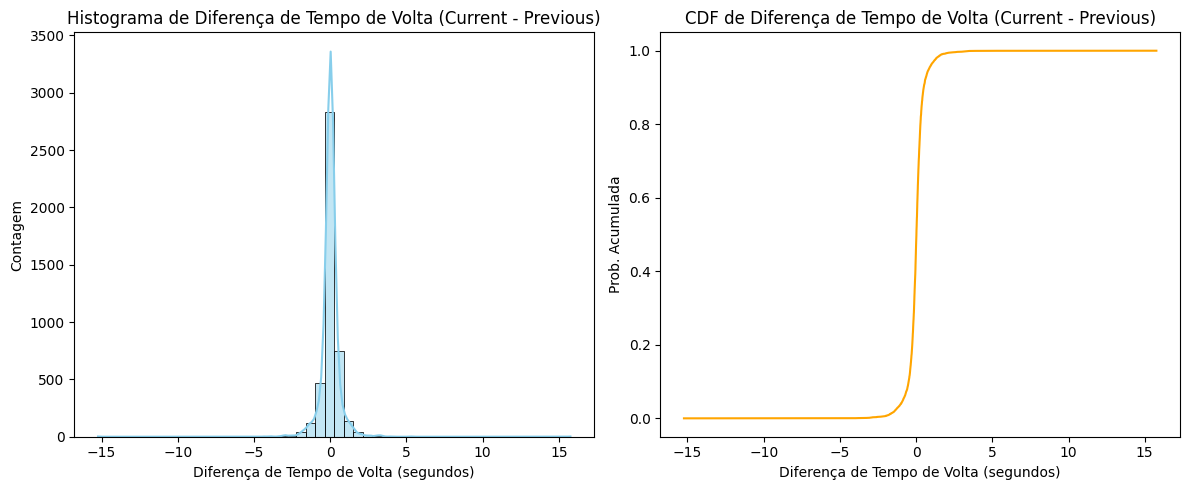

In [7]:
laps_with_weather['laps_diff'] = laps_with_weather['LapTime_seconds'] - laps_with_weather['LapTime_prev']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(laps_with_weather['laps_diff'].dropna(), kde=True, bins=50, color='skyblue')
plt.title('Histograma de Diferença de Tempo de Volta (Current - Previous)')
plt.xlabel('Diferença de Tempo de Volta (segundos)')
plt.ylabel('Contagem')
plt.subplot(1, 2, 2)
sorted_diff = np.sort(laps_with_weather['laps_diff'].dropna())
cdf_vals = np.arange(1, len(sorted_diff)+1) / len(sorted_diff)
plt.plot(sorted_diff, cdf_vals, color='orange')
plt.title('CDF de Diferença de Tempo de Volta (Current - Previous)')
plt.xlabel('Diferença de Tempo de Volta (segundos)')
plt.ylabel('Prob. Acumulada')
plt.tight_layout()
plt.show()

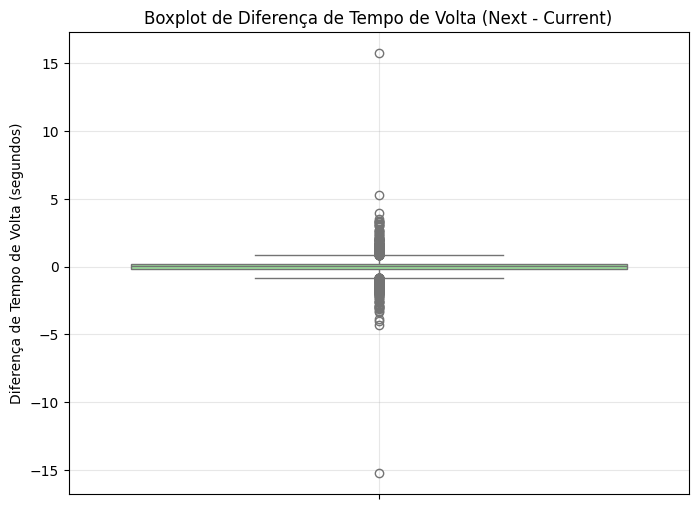

--- CANDIDATOS A CORTE PERFEITO ---
1. Conservador (Top 1%):  [-1.77s, 1.69s]
   (Remove apenas Pit Stops e SCs graves)

2. Padrão Estatístico (IQR): [-0.82s, 0.85s]
   (O mais aceito academicamente para 'outliers')

3. Rigoroso (Top 5%):     [-0.85s, 0.83s]
   (Deixa apenas voltas muito consistentes)


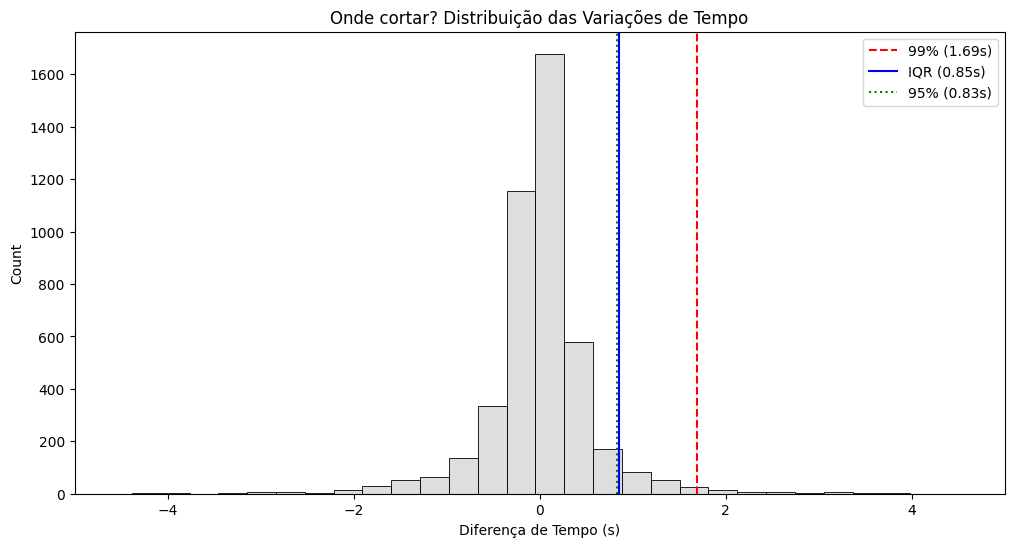

In [8]:
diff_data = laps_with_weather['laps_diff'].dropna()


# Box plot para visualizar outliers
plt.figure(figsize=(8, 6))
sns.boxplot(y=laps_with_weather['laps_diff'].dropna(), color='lightgreen')
plt.title('Boxplot de Diferença de Tempo de Volta (Next - Current)')
plt.ylabel('Diferença de Tempo de Volta (segundos)')
plt.grid(alpha=0.3)
plt.show()

# --- OPÇÃO A: CORTE POR PERCENTIL (1% e 99%) ---
p1 = np.percentile(diff_data, 1)
p99 = np.percentile(diff_data, 99)

# --- OPÇÃO B: CORTE POR IQR (Padrão Estatístico) ---
Q1 = np.percentile(diff_data, 25)
Q3 = np.percentile(diff_data, 75)
IQR = Q3 - Q1
lower_iqr = Q1 - 1.5 * IQR
upper_iqr = Q3 + 1.5 * IQR

# --- OPÇÃO C: CORTE RIGOROSO (5% e 95%) ---
p5 = np.percentile(diff_data, 5)
p95 = np.percentile(diff_data, 95)

print("--- CANDIDATOS A CORTE PERFEITO ---")
print(f"1. Conservador (Top 1%):  [{p1:.2f}s, {p99:.2f}s]")
print(f"   (Remove apenas Pit Stops e SCs graves)")
print(f"\n2. Padrão Estatístico (IQR): [{lower_iqr:.2f}s, {upper_iqr:.2f}s]")
print(f"   (O mais aceito academicamente para 'outliers')")
print(f"\n3. Rigoroso (Top 5%):     [{p5:.2f}s, {p95:.2f}s]")
print(f"   (Deixa apenas voltas muito consistentes)")

plt.figure(figsize=(12, 6))
sns.histplot(diff_data, bins=100, kde=False, color='lightgray')

plt.xlim(-5, 5) 

# Linhas de corte
plt.axvline(p99, color='red', linestyle='--', label=f'99% ({p99:.2f}s)')
plt.axvline(upper_iqr, color='blue', linestyle='-', label=f'IQR ({upper_iqr:.2f}s)')
plt.axvline(p95, color='green', linestyle=':', label=f'95% ({p95:.2f}s)')

plt.title('Onde cortar? Distribuição das Variações de Tempo')
plt.xlabel('Diferença de Tempo (s)')
plt.legend()
plt.show()


In [9]:
mask_clean = (
    (laps_with_weather['laps_diff'] >= p5) &
    (laps_with_weather['laps_diff'] <= p95)
)

laps_cleaned = laps_with_weather[mask_clean].copy()

print(f"Total original: {len(laps_with_weather)}")
print(f"Total após filtro: {len(laps_cleaned)}")
print(f"Outliers removidos (Voltas lentas/Pit In): {len(laps_with_weather) - len(laps_cleaned)}")


Total original: 4646
Total após filtro: 3987
Outliers removidos (Voltas lentas/Pit In): 659


## 5. Análise Univariada: Distribuição das Variáveis Contínuas

Antes de modelar as relações entre as variáveis, é crucial entender o comportamento individual de cada uma. Nesta etapa, geramos **histogramas com estimativa de densidade (KDE)** para todas as variáveis numéricas contínuas.

Os objetivos desta visualização são:
1.  **Verificar Normalidade:** Modelos lineares performam melhor quando os resíduos são normais. Observar se variáveis como `LapTime_seconds` possuem uma distribuição "em sino" ou se são fortemente assimétricas (*skewed*) nos ajuda a decidir sobre transformações matemáticas.
2.  **Identificar Caudas (Outliers):** Em dados de corrida, esperamos distribuições com caudas longas à direita para os tempos de volta (representando voltas lentas, erros ou Safety Cars), enquanto variáveis físicas como `TyreLife` tendem a ter distribuições mais uniformes ou decrescentes.
3.  **Detectar Multimodalidade:** Para variáveis climáticas (`TrackTemp`, `WindDirection`), múltiplos picos podem indicar mudanças drásticas no ambiente durante a corrida (ex: o sol se pondo no Bahrein), o que justifica o uso de técnicas como RBF.

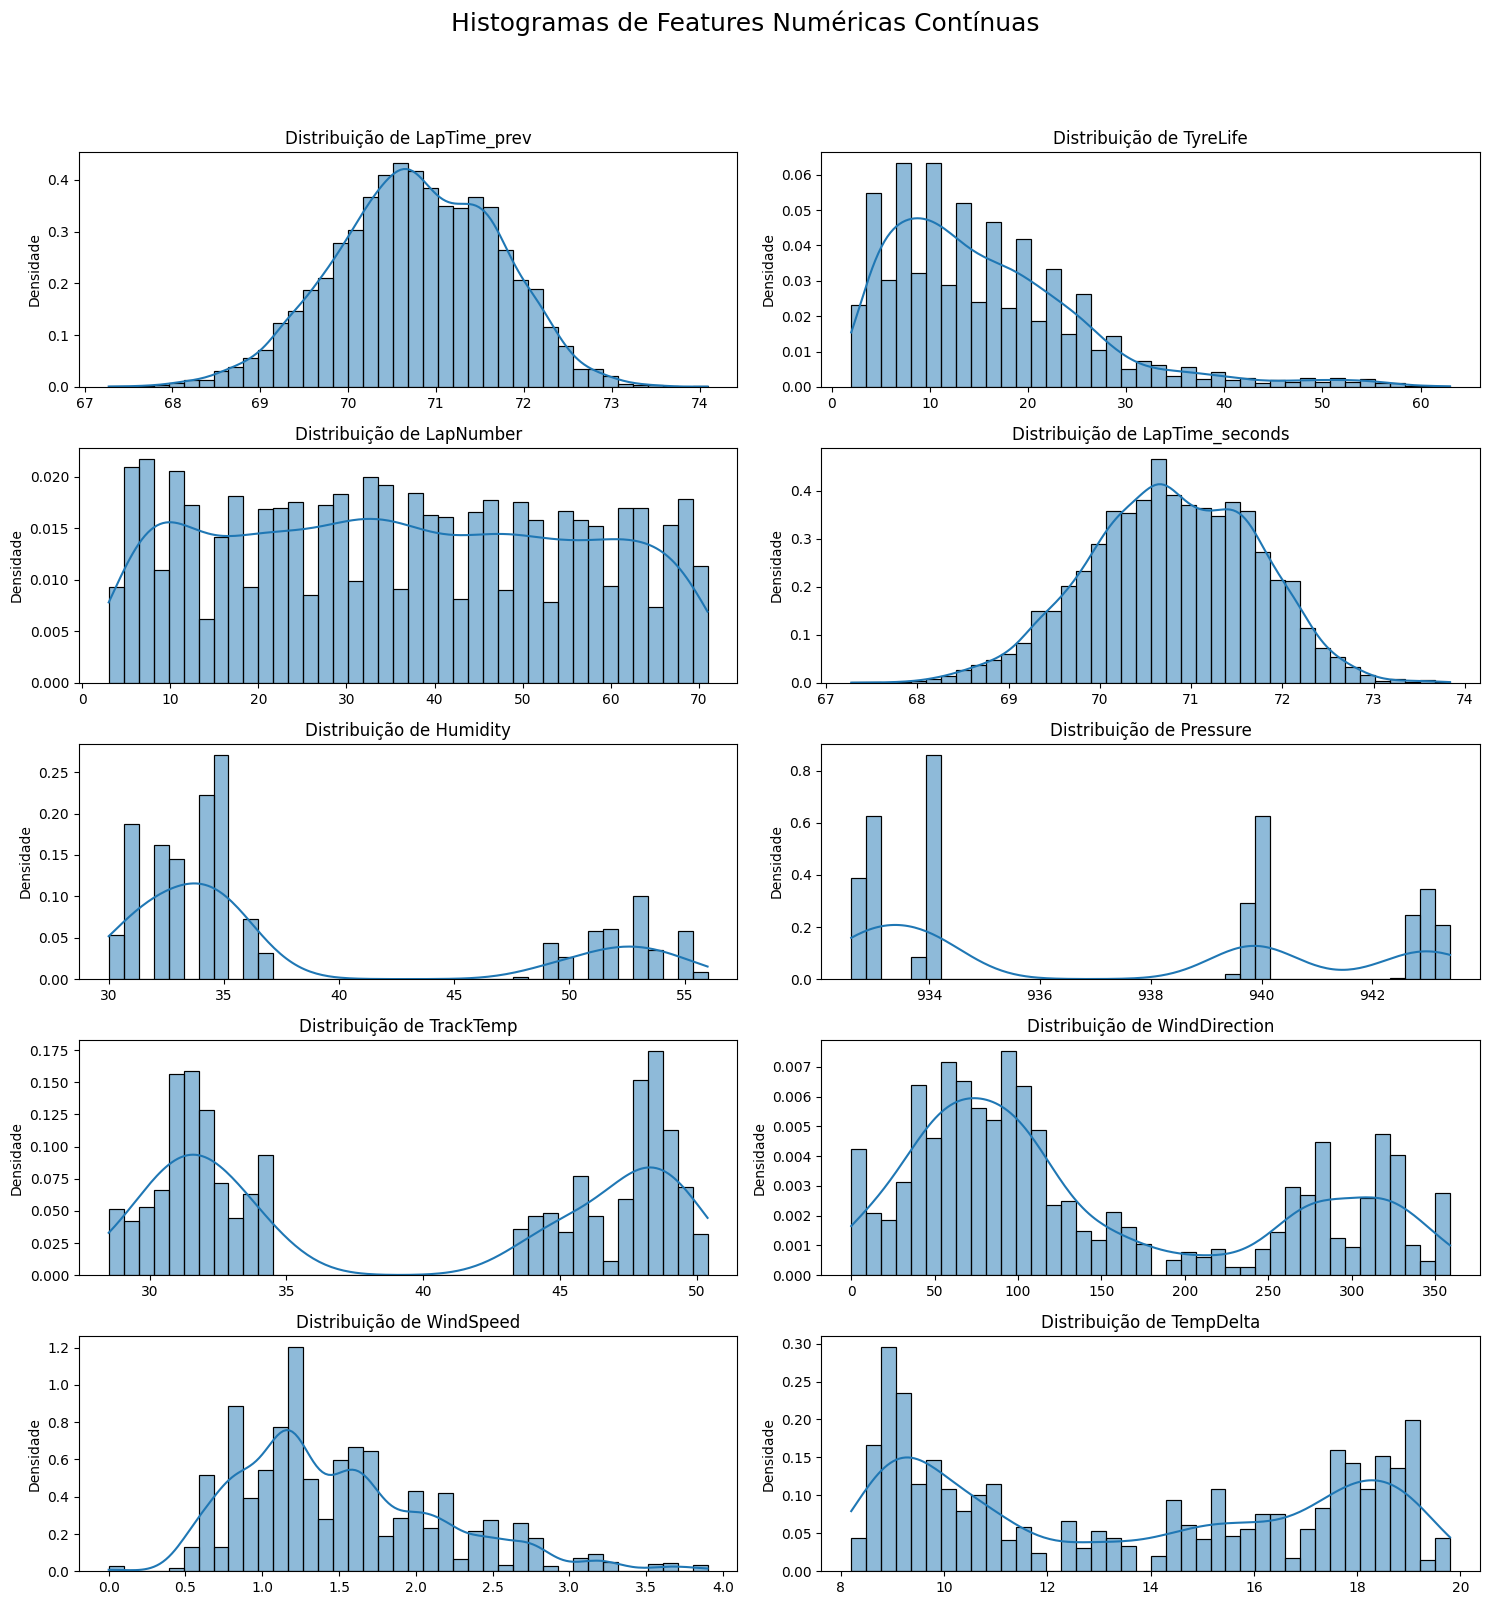

In [10]:
n_rows_cont = 5
n_cols_cont = 2
fig_cont, axes_cont = plt.subplots(n_rows_cont, n_cols_cont, figsize=(15, 16))
flat_axes_cont = axes_cont.flatten() 

continuous_cols = [
    'LapTime_prev', 'TyreLife', 'LapNumber', 'LapTime_seconds', 'Humidity', 
    'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'TempDelta'
]

num_df = laps_cleaned[continuous_cols].copy()

for i, col in enumerate(continuous_cols):
    ax = flat_axes_cont[i]
    
    data_to_plot = num_df[col].dropna()
    
    if data_to_plot.empty:
        ax.set_title(f'{col} (Sem Dados)')
        ax.text(0.5, 0.5, 'Sem Dados', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_xticks([]); ax.set_yticks([])
    else:
        sns.histplot(data_to_plot, kde=True, ax=ax, bins=40, stat="density") 
        ax.set_title(f'Distribuição de {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Densidade') 

plt.suptitle('Histogramas de Features Numéricas Contínuas', fontsize=18, y=1.03)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])

TyreLife pode ser melhor visualizada através de histogramas separados, que separam por compostos de pneu.

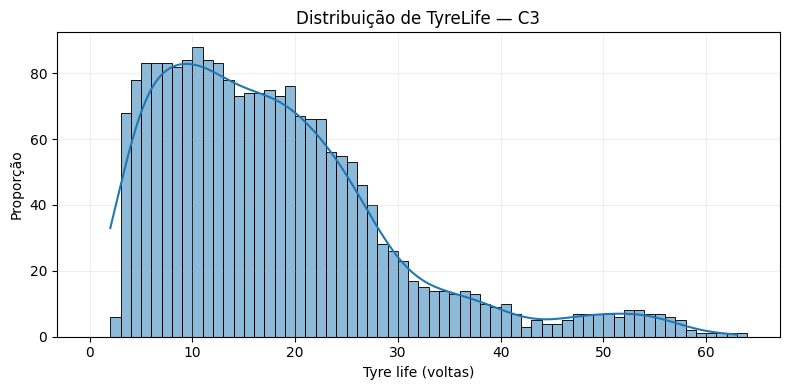

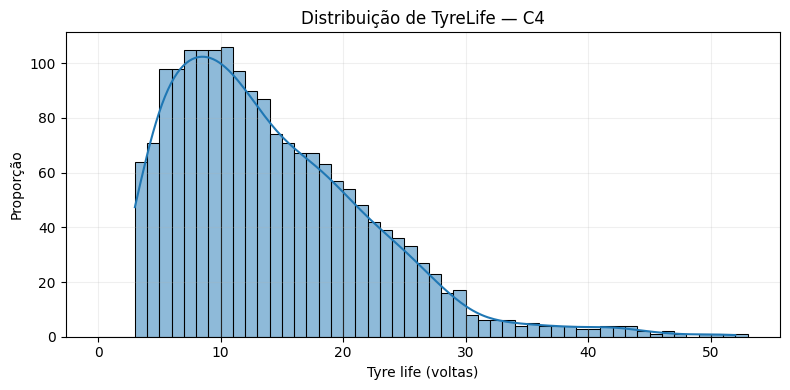

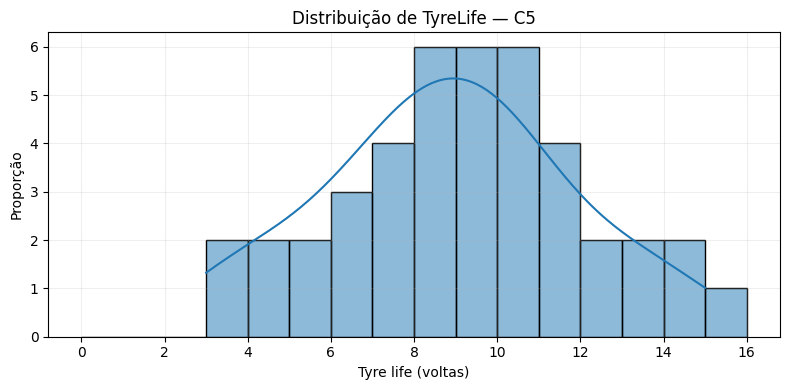

In [11]:
compounds_to_plot = ['C3','C4','C5']

for comp in compounds_to_plot:
    if 'pirelliCompound' in laps_cleaned.columns:
        subset = laps_cleaned[laps_cleaned['pirelliCompound'] == comp]
    elif 'Compound' in laps_cleaned.columns:
        subset = laps_cleaned[laps_cleaned['Compound'] == comp]
    else:
        subset = laps_cleaned[laps_cleaned.get('compound') == comp] if 'compound' in laps_cleaned.columns else laps_cleaned[[]]

    if subset.empty:
        print(f'Nenhum dado disponível para o composto {comp}. Pulando.')
        continue

    tyre_life = subset['TyreLife'].dropna()
    if tyre_life.empty:
        print(f'Nenhum TyreLife válido para {comp}. Pulando.')
        continue

    max_life = int(tyre_life.max()) if pd.api.types.is_numeric_dtype(tyre_life) else tyre_life.max()
    bins = range(0, max(2, max_life + 2)) if isinstance(max_life, int) else 10

    plt.figure(figsize=(8,4))
    sns.histplot(tyre_life, bins=bins, kde=True, color='C0', stat='count')
    plt.title(f'Distribuição de TyreLife — {comp}')
    plt.xlabel('Tyre life (voltas)')
    plt.ylabel('Proporção')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


## 6. Análise de Distribuição Acumulada (CDF)

Enquanto os histogramas nos dão uma noção visual da "forma" dos dados, a **Função de Distribuição Acumulada (CDF)** oferece uma leitura probabilística precisa, livre dos artefatos de binagem (escolha do tamanho das barras) que podem distorcer histogramas.

Nesta etapa, calculamos a CDF empírica ($F(x) = P(X \le x)$) para cada variável contínua, afim de **quantificar os outliers** e **verificar assimetria**.

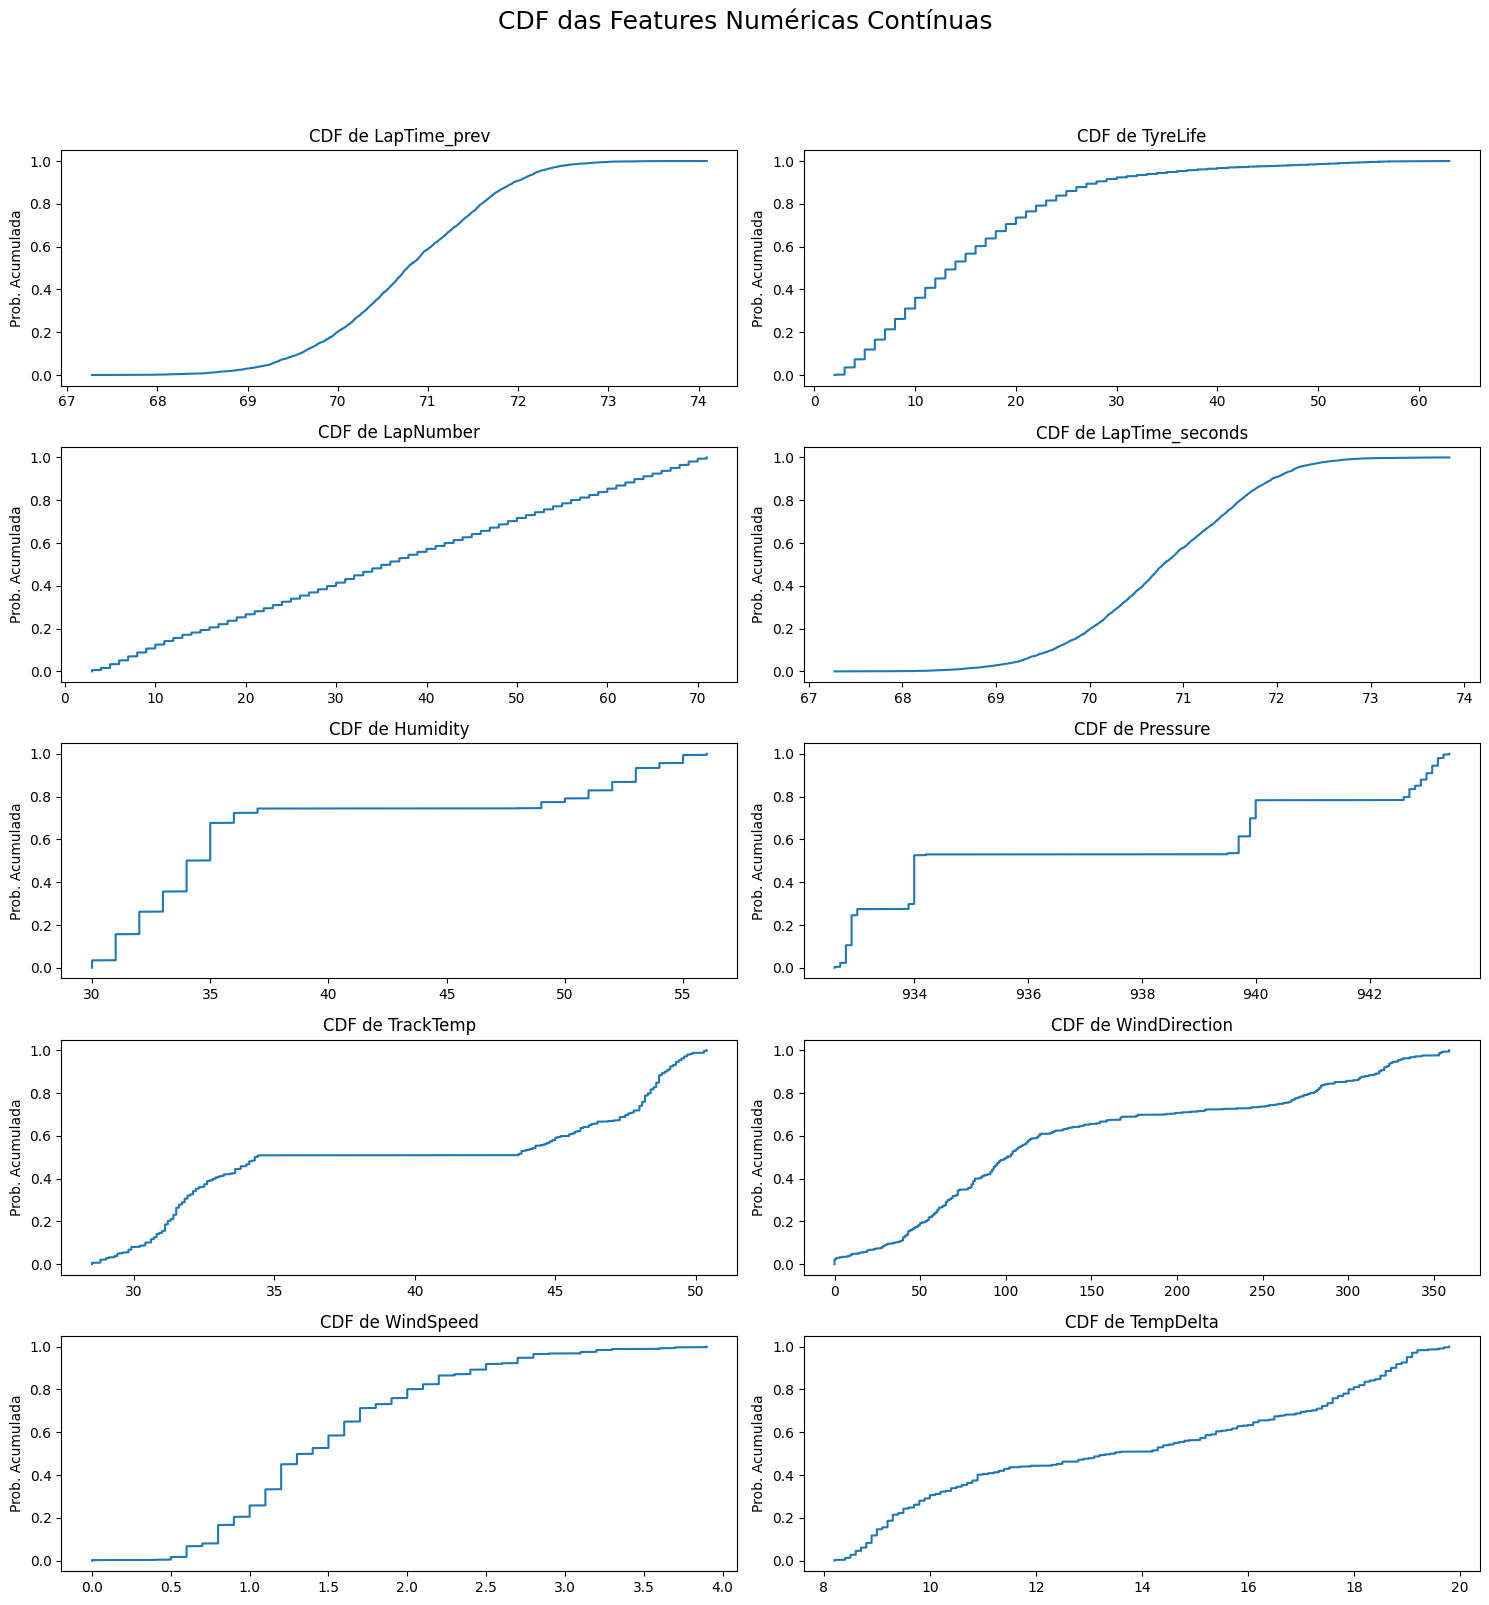

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

fig_cdf, axes_cdf = plt.subplots(n_rows_cont, n_cols_cont, figsize=(15, 16))
flat_axes_cdf = axes_cdf.flatten()


for i, col in enumerate(continuous_cols):
    ax = flat_axes_cdf[i]

    data_to_plot = num_df[col].dropna()

    if data_to_plot.empty:
        ax.set_title(f'{col} (Sem Dados)')
        ax.text(0.5, 0.5, 'Sem Dados', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_xticks([]); ax.set_yticks([])
    else:

        sorted_vals = np.sort(data_to_plot)
        cdf_vals = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)

        ax.plot(sorted_vals, cdf_vals)
        ax.set_title(f'CDF de {col}')
        ax.set_xlabel('')
        ax.set_ylabel('Prob. Acumulada')

plt.suptitle('CDF das Features Numéricas Contínuas', fontsize=18, y=1.03)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])


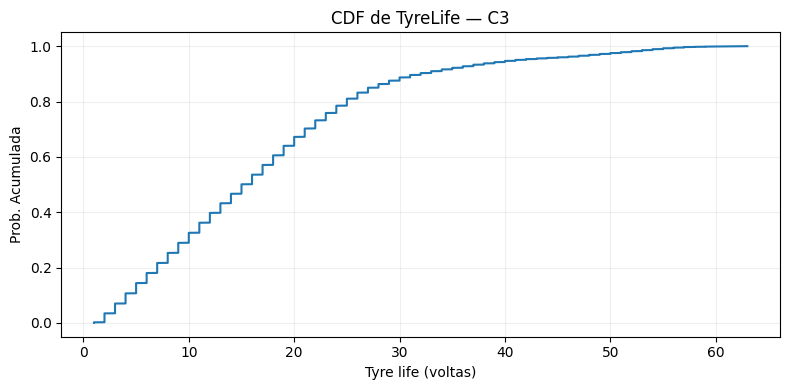

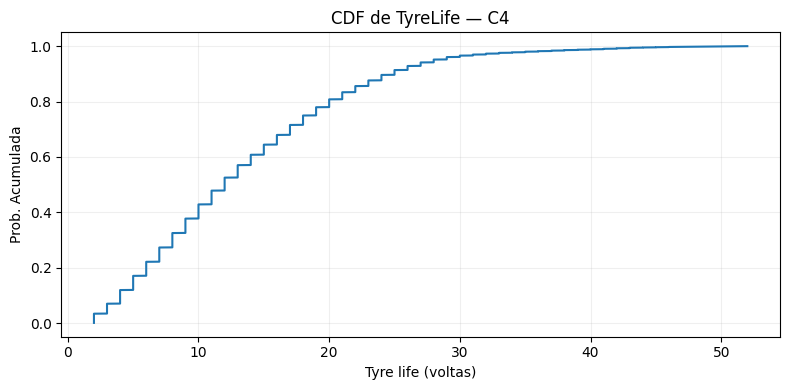

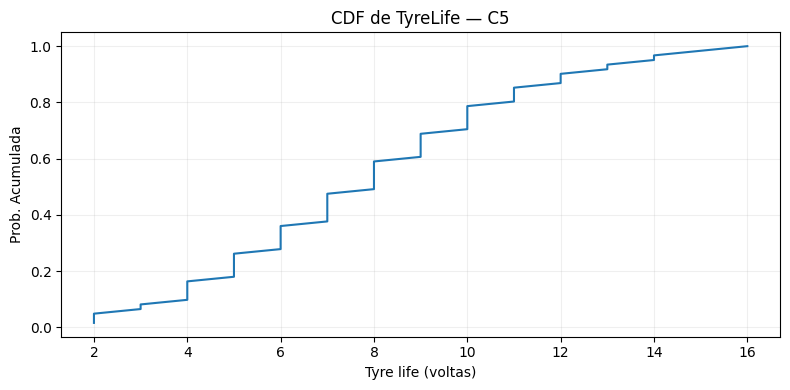

In [13]:
# Fazer um grafico separado para composto CDF separado para cada composto
for comp in compounds_to_plot:
    if 'pirelliCompound' in laps_with_weather.columns:
        subset = laps_with_weather[laps_with_weather['pirelliCompound'] == comp]
    elif 'Compound' in laps_with_weather.columns:
        subset = laps_with_weather[laps_with_weather['Compound'] == comp]
    else:
        subset = laps_with_weather[laps_with_weather.get('compound') == comp] if 'compound' in laps_with_weather.columns else laps_with_weather[[]]

    if subset.empty:
        print(f'Nenhum dado disponível para o composto {comp}. Pulando.')
        continue

    tyre_life = subset['TyreLife'].dropna()
    if tyre_life.empty:
        print(f'Nenhum TyreLife válido para {comp}. Pulando.')
        continue

    sorted_vals = np.sort(tyre_life)
    cdf_vals = np.arange(1, len(sorted_vals)+1) / len(sorted_vals)

    plt.figure(figsize=(8,4))
    plt.plot(sorted_vals, cdf_vals, color='C0')
    plt.title(f'CDF de TyreLife — {comp}')
    plt.xlabel('Tyre life (voltas)')
    plt.ylabel('Prob. Acumulada')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()


## 7. Análise de Frequência: Variáveis Categóricas e Balanceamento

Nesta etapa, investigamos a distribuição das variáveis qualitativas para identificar desequilíbrios no conjunto de dados que possam afetar o treinamento do modelo. Utilizamos gráficos de barras de frequência (*Countplots*) para visualizar quatro dimensões críticas:

1.  **Pilotos (`Driver`) e Equipes (`Team`):**
    * Idealmente, a distribuição deveria ser uniforme (todos completando todas as voltas).
    * **Insight:** Barras menores indicam pilotos que sofreram abandonos (DNF - *Did Not Finish*) nas temporadas analisadas ou que disputaram menos corridas nesse período, tendo entrado na categoria tardiamente (ou mesmo saído precocemente). Isso alerta que o modelo terá menos exemplos de treinamento para esses pilotos/equipes específicos.

2.  **Compostos de Pneus (`pirelliCompound`):**
    * Revela a "Estratégia Padrão" do circuito.
    * **Insight:** A frequência relativa entre compostos (ex: muito uso de C3 vs. pouco uso de C1) indica quais pneus são preferidos pelas equipes no Bahrein. Isso ajuda a validar se o modelo está aprendendo a performance dos pneus mais relevantes.



3.  **Status da Pista (`TrackStatus`):**
    * Variável fundamental para a limpeza de dados.
    * **Insight:** O código `1` representa **Pista Limpa** (Green Flag). A proporção visual entre o status `1` e os demais (Safety Car, VSC, Bandeira Amarela) nos dá a magnitude de "ruído" que precisaremos filtrar para isolar o ritmo de corrida puro.

Gerando gráficos de frequência (Countplots) para variáveis categóricas...


C:\Users\mpoli\AppData\Local\Temp\ipykernel_22652\3875288547.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_to_plot, ax=ax, order=bar_order, palette="viridis")
C:\Users\mpoli\AppData\Local\Temp\ipykernel_22652\3875288547.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\mpoli\AppData\Local\Temp\ipykernel_22652\3875288547.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=data_to_plot, ax=ax, order=bar_order, palette="viridis")
C:\Users\mpoli\AppData\Local\Temp\ipykernel_22652\3875288547.py:36: UserWarning: set

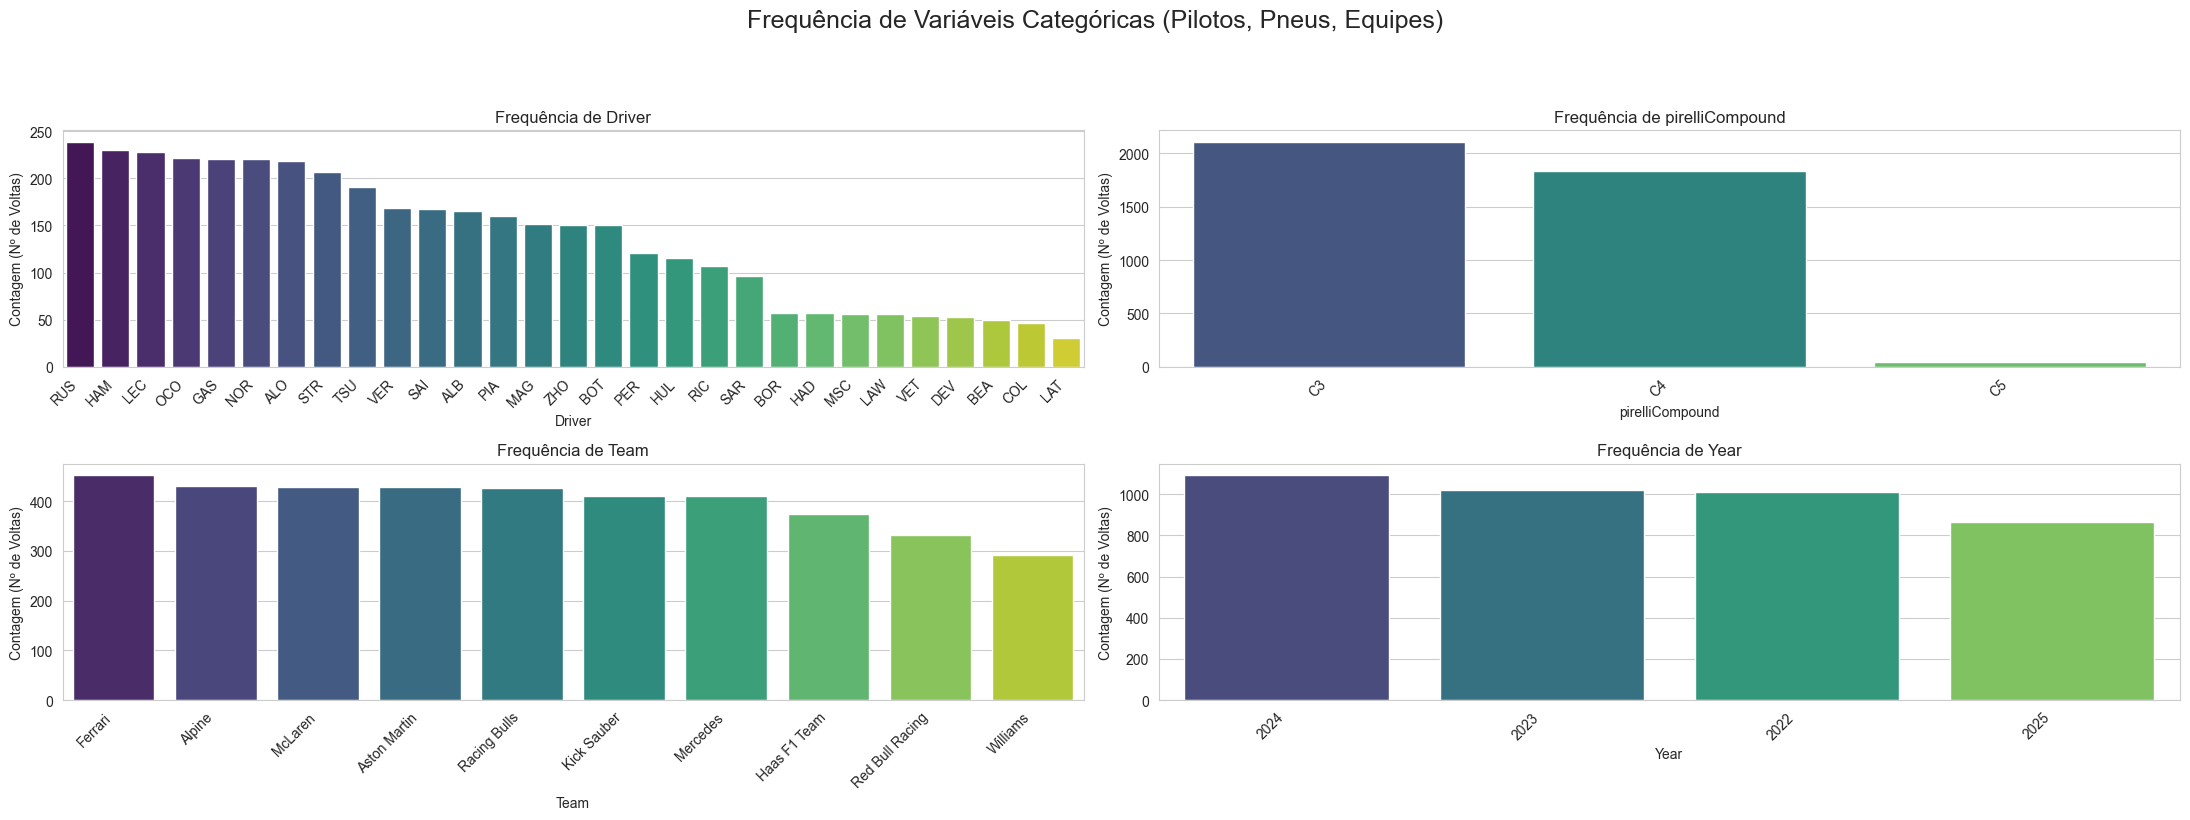

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

cat_cols = ['Driver', 'pirelliCompound', 'Team', 'Year']

print("Gerando gráficos de frequência (Countplots) para variáveis categóricas...")

sns.set_style("whitegrid")

n_rows_cat = 2
n_cols_cat = 2
fig_cat, axes_cat = plt.subplots(n_rows_cat, n_cols_cat, figsize=(22, 8)) 

flat_axes_cat = axes_cat.flatten()

for i, col in enumerate(cat_cols):
    ax = flat_axes_cat[i]
    
    data_to_plot = laps_cleaned[col].dropna()
    
    if data_to_plot.empty:
        ax.set_title(f'Frequência de {col} (Sem Dados)')
        ax.text(0.5, 0.5, 'Sem Dados', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_xticks([]); ax.set_yticks([])
    else:
        bar_order = data_to_plot.value_counts().index
        
        sns.countplot(x=data_to_plot, ax=ax, order=bar_order, palette="viridis")
        
        ax.set_title(f'Frequência de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Contagem (Nº de Voltas)')
        
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.suptitle('Frequência de Variáveis Categóricas (Pilotos, Pneus, Equipes)', fontsize=18, y=1.05)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])

plt.show()

A variável **TrackStatus** é um combinação de flags númericas que indica o que aconteceu durante aquela volta:

* 1: Pista Livre;
* 2: Bandeira Amarela;
* 3 ??? (Erro);
* 4: Safety Car
* 5: Banderia Vermelha;
* 6: Começo de Virtual Safety Car;
* 7: Final de Virtual Safety Car;

A string '12' por exemplo, indica bandeira verde e amarela durante a mesma volta. Como apenas trabalhamos com voltas que atendam ao `isAccurate`, lidamos quase que em grande parte do tempo com apenas voltas em pista livre. Portanto, retirei essa análise daqui.
Caso o estudo seja replicado com todas as voltas, sem uma espécie de limpeza sendo realizado, talvez seja interessante o uso e análise da variável.


## 8. Detecção de Outliers e Dispersão Estatística (Boxplots)

Para complementar a análise de distribuição, utilizamos **Boxplots** (Diagramas de Caixa) para visualizar a dispersão dos dados e identificar explicitamente os valores discrepantes (*outliers*).

A interpretação desta matriz de gráficos é crucial para a limpeza de dados subsequente:

1.  **A "Caixa" (IQR):** Representa os 50% centrais dos dados (do 25º ao 75º percentil). Uma caixa "alta" indica alta variabilidade, enquanto uma caixa "achatada" indica consistência.
2.  **Os "Bigodes" e Outliers:** Os pontos individuais plotados acima ou abaixo dos limites ("bigodes") são estatisticamente anômalos.
    * **Em `LapTime_seconds`:** A presença de muitos pontos acima do limite superior confirma visualmente a existência de voltas que são errros do piloto, como já filtramos as voltas de pit, VSC e SC anterioremnte.
    * **Em Variáveis de Sensores:** Pontos isolados extremos em variáveis como `Pressure` ou `TrackTemp` podem indicar falhas momentâneas de leitura do sensor ou eventos climáticos raros.

C:\Users\mpoli\AppData\Local\Temp\ipykernel_22652\3236262630.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=data_to_plot, ax=ax, palette="viridis")
C:\Users\mpoli\AppData\Local\Temp\ipykernel_22652\3236262630.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=data_to_plot, ax=ax, palette="viridis")
C:\Users\mpoli\AppData\Local\Temp\ipykernel_22652\3236262630.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=data_to_plot, ax=ax, palette="viridis")
C:\Users\mpoli\AppData\Local\Temp\ipykernel_22652\3236262630.py:18: FutureWarni

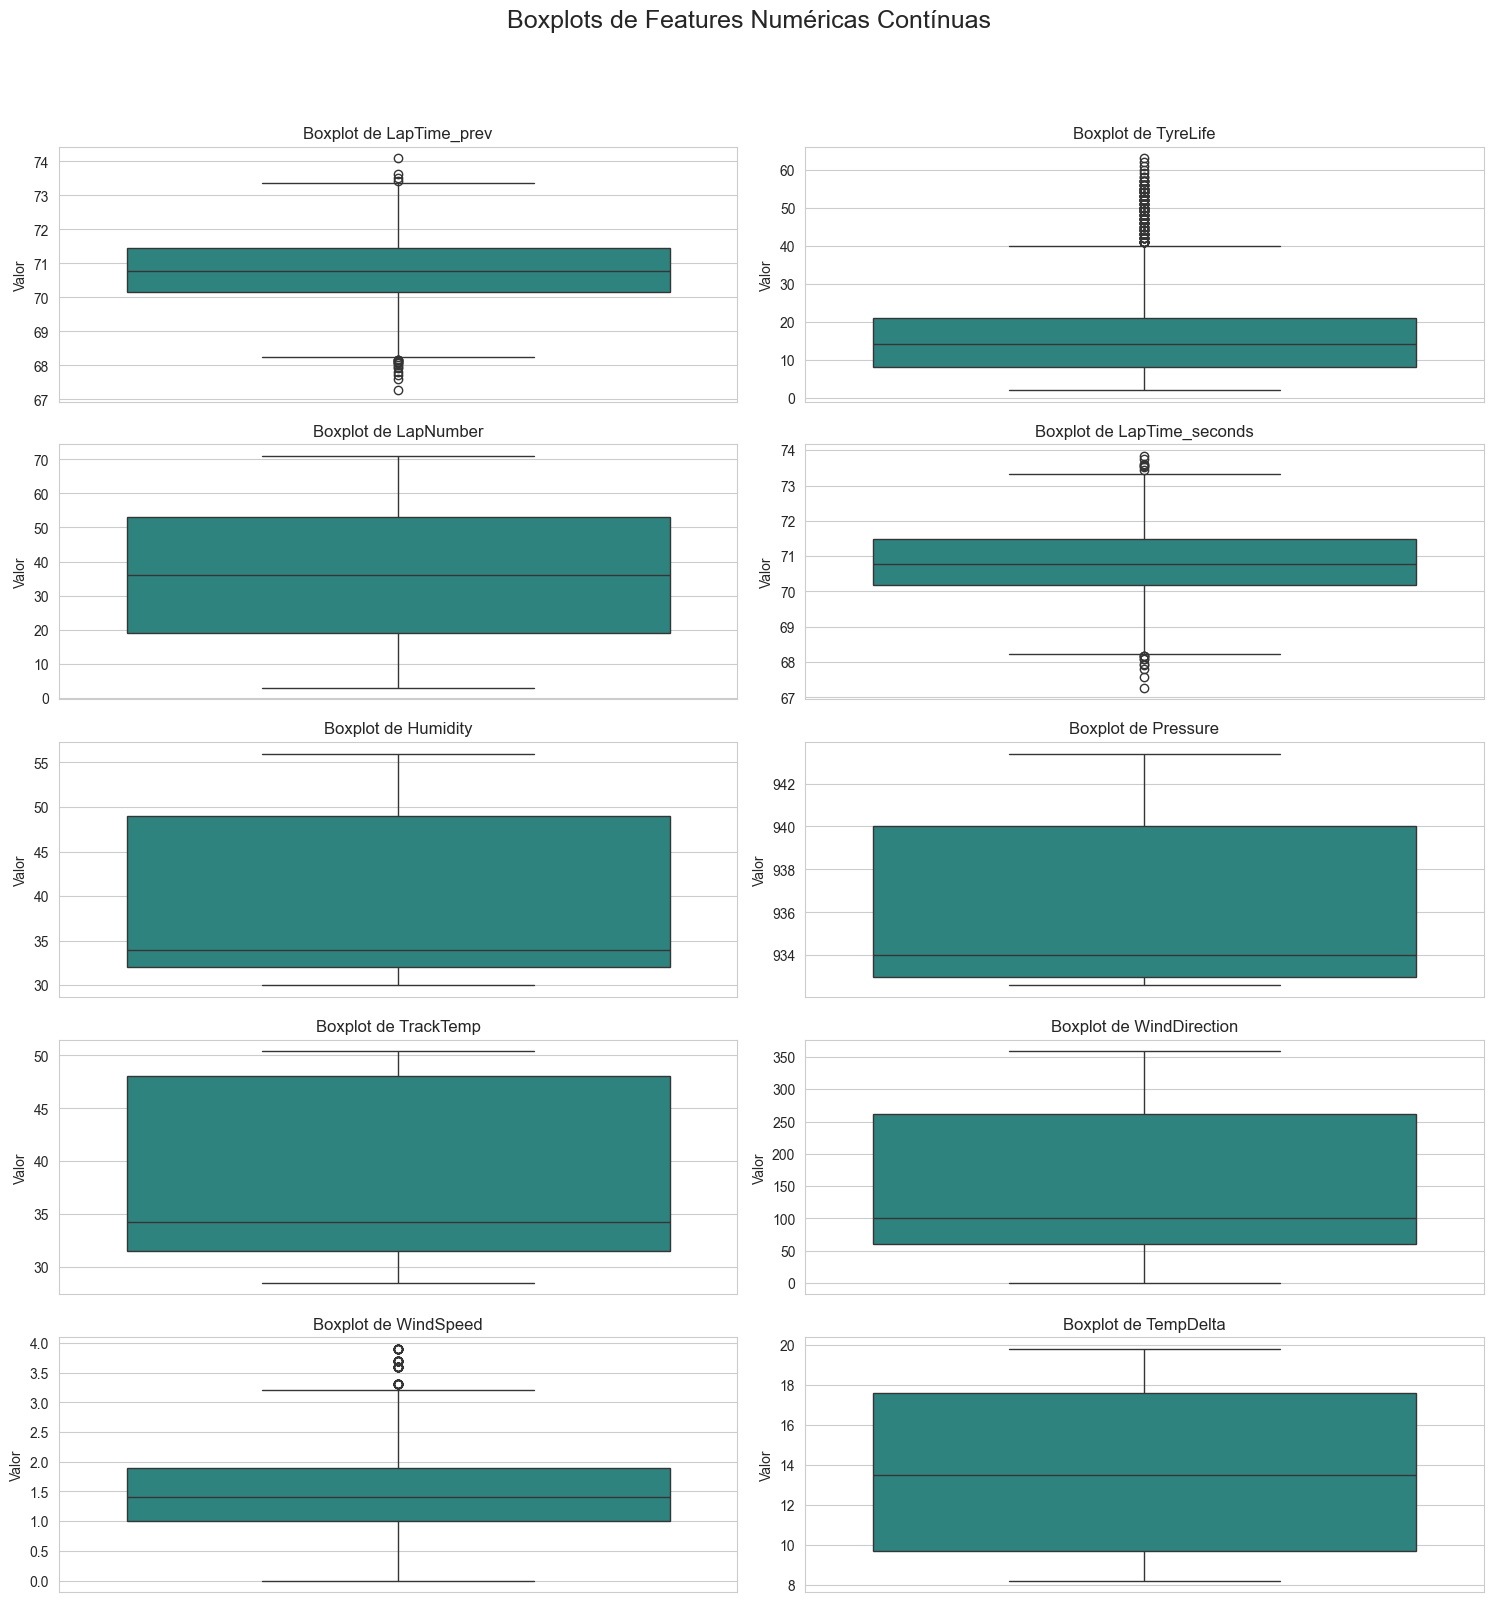

In [15]:
n_rows = 5
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 16))
flat_axes = axes.flatten()

sns.set_style("whitegrid")

for i, col in enumerate(continuous_cols):
    ax = flat_axes[i]
    
    data_to_plot = laps_cleaned[col].dropna()
    
    if data_to_plot.empty:
        ax.set_title(f'Boxplot de {col} (Sem Dados)')
        ax.text(0.5, 0.5, 'Sem Dados', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        ax.set_xticks([]); ax.set_yticks([])
    else:
        sns.boxplot(y=data_to_plot, ax=ax, palette="viridis") 
        ax.set_title(f'Boxplot de {col}')
        ax.set_xlabel('') 
        ax.set_ylabel('Valor')
            
plt.suptitle('Boxplots de Features Numéricas Contínuas', fontsize=18, y=1.03)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

## 9. Estatísticas Descritivas e Momentos da Distribuição

Para formalizar a análise exploratória, calculamos uma tabela de estatísticas descritivas expandida, incluindo métricas de forma da distribuição (*Momentos Estatísticos*) e de variabilidade relativa.

Além das medidas padrão (média, desvio padrão, quartis), incluímos:

1.  **Assimetria (*Skewness*):** Mede o desvio da distribuição em relação à simetria de uma normal.

2.  **Curtose (*Kurtosis*):** Mede o "peso" das caudas e a propensão a *outliers*.

3.  **Coeficiente de Variação (CV):** Medida adimensional de dispersão ($\sigma / \mu$).


In [16]:
try:
    stats_df = laps_cleaned.describe(include='all')

    features_interesse = [
    'LapTime_prev', 'TyreLife', 'LapNumber', 'LapTime_seconds',
    'Humidity', 'Pressure', 'TrackTemp', 'WindDirection', 'WindSpeed', 'TempDelta'
    ]

    skewness = laps_cleaned.skew(numeric_only=True)

    kurtosis = laps_cleaned.kurt(numeric_only=True)

    means = laps_cleaned.mean(numeric_only=True)
    stds = laps_cleaned.std(numeric_only=True)

    cv = np.where(means == 0, np.nan, stds / means)
    
    cv_series = pd.Series(cv, index=means.index)

    stats_df = stats_df[features_interesse]

    stats_df.loc['skewness'] = skewness
    stats_df.loc['kurtosis'] = kurtosis
    stats_df.loc['CV (Coef. Var)'] = cv_series


    print("\n--- Estatísticas ---")
    display(stats_df)
    

except Exception as e:
    print(f"Ocorreu um erro ao calcular as estatísticas: {e}")
    print("Verifique se o DataFrame 'laps_with_weather' existe e não está vazio.")


--- Estatísticas ---


,LapTime_prev,TyreLife,LapNumber,LapTime_seconds,Humidity,Pressure,TrackTemp,WindDirection,WindSpeed,TempDelta
count,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000,3987.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,70.777738,15.853775,36.234512,70.791734,38.206170,937.115877,39.418560,142.525959,1.509506,13.624179
min,67.275000,2.000000,3.000000,67.275000,30.000000,932.600000,28.500000,0.000000,0.000000,8.200000
25%,70.162000,8.000000,19.000000,70.167500,32.000000,933.000000,31.500000,60.000000,1.000000,9.700000
50%,70.769000,14.000000,36.000000,70.785000,34.000000,934.000000,34.300000,101.000000,1.400000,13.500000
75%,71.461500,21.000000,53.000000,71.473000,49.000000,940.000000,48.100000,262.000000,1.900000,17.600000
max,74.091000,63.000000,71.000000,73.839000,56.000000,943.400000,50.400000,359.000000,3.900000,19.800000


## 10. Diagnóstico de Assimetria e Necessidade de Transformações

A assimetria (*skewness*) é um indicador crítico para a escolha de algoritmos de Machine Learning. Muitos modelos (especialmente regressão linear) assumem que os resíduos e as variáveis preditoras seguem uma distribuição normal (assimetria $\approx 0$).

Nesta etapa, filtramos automaticamente as variáveis que violam essa premissa, utilizando um limiar de corte de $|1.0|$:

1.  **Right Skewed (Assimetria Positiva $> 1$):**
    * Indica uma concentração de valores baixos com uma cauda longa de valores altos.
    * *Ação:* Estas variáveis são candidatas fortes a transformação logarítmica (`np.log1p`).

2.  **Left Skewed (Assimetria Negativa $< -1$):**
    * Indica concentração em valores altos com cauda de valores baixos.

Identificar essas distorções *a priori* impede que o modelo seja enviesado por valores extremos raros.

In [17]:
# Quais features da tabela têm:
# - skewness > 1
# - skewness < -1
# stats_df já foi calculado anteriormente
skewed_features = {
    'right_skewed': [],
    'left_skewed': []
}

for feature in stats_df.columns:
    skewness_value = stats_df.at['skewness', feature]
    if pd.notna(skewness_value):
        if skewness_value > 1:
            skewed_features['right_skewed'].append(feature)
        elif skewness_value < -1:
            skewed_features['left_skewed'].append(feature)

print("\n--- Features com Skewness Significativo ---")
print("Right Skewed (skewness > 1):", skewed_features['right_skewed'])
print("Left Skewed (skewness < -1):", skewed_features['left_skewed'])



--- Features com Skewness Significativo ---
Right Skewed (skewness > 1): ['TyreLife', 'Humidity']
Left Skewed (skewness < -1): []


## 11. Análise de Estratégia: Matriz de Transição de Compostos

Na Fórmula 1, a estratégia de corrida é definida pela sequência de pneus utilizados. Entender as trocas mais comuns (o "Meta-Game") é crucial para prever o comportamento das equipes.

Nesta etapa, construímos uma **Matriz de Transição de Markov** empírica. O objetivo é responder: *"Dado que um piloto está usando o composto X no Stint atual, qual a probabilidade de ele mudar para o composto Y no próximo Stint?"*

A metodologia consiste em:
1.  **Agrupamento por Stint:** Reduzimos o dataset para ter apenas uma linha por jogo de pneus utilizado por cada piloto em cada ano.
2.  **Pareamento Temporal ($t \to t+1$):** Criamos colunas deslocadas (*shifted*) para alinhar o pneu atual (`From_Compound`) com o pneu do próximo stint (`To_Compound`).
3.  **Visualização:** O Heatmap resultante revela as estratégias dominantes.
    * **Bahrein (Sakhir):** Como é uma pista de alta degradação, esperamos ver forte fluxo de pneus mais macios (C3) para pneus mais duros (C1 ou C2). Transições `C3 -> C3` devem ser raras, indicando estratégias agressivas de múltiplas paradas.

Analisando transições de compostos entre stints...

--- Matriz de Contagem de Transição de Stints ---


To_Compound,C3,C4,C5
From_Compound,,,
C3,18,33,1
C4,61,15,2
C5,2,2,0



Gerando heatmap da matriz de transição...


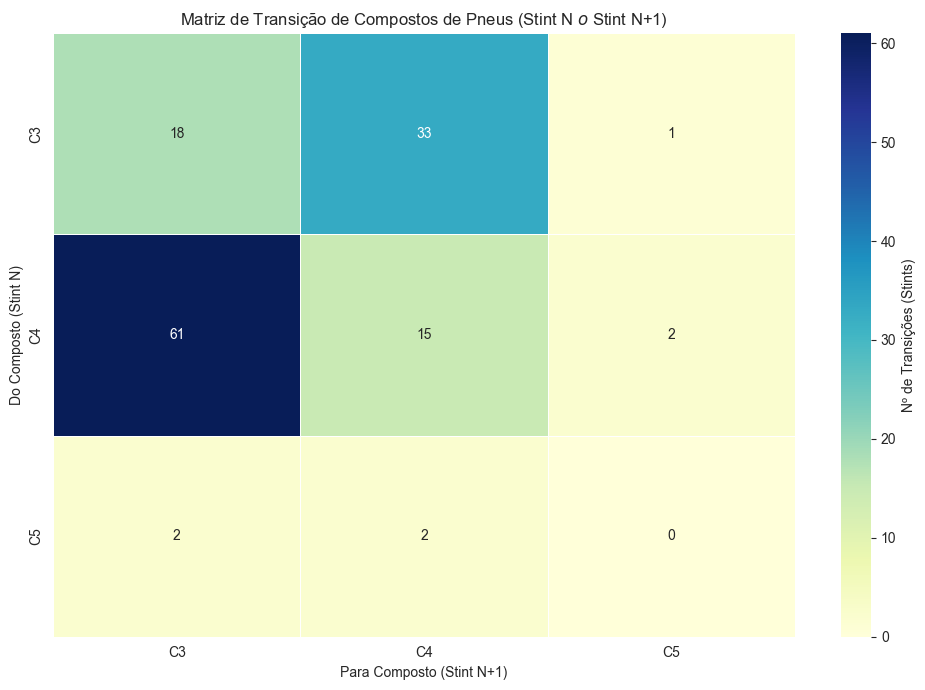

In [18]:
print("Analisando transições de compostos entre stints...")

try:

    stint_df = laps_cleaned[
        ['Year', 'Driver', 'Stint', 'pirelliCompound']
    ].drop_duplicates()
    
    stint_df = stint_df.sort_values(by=['Year', 'Driver', 'Stint'])

    stint_df['To_Compound'] = stint_df.groupby(['Year', 'Driver'])['pirelliCompound'].shift(-1)
    
    stint_df = stint_df.rename(columns={'pirelliCompound': 'From_Compound'})
    
    transitions_df = stint_df.dropna(subset=['To_Compound'])

    if transitions_df.empty:
        print("Não foi possível encontrar dados de transição (múltiplos stints) no DataFrame.")
    else:
        transition_matrix = pd.crosstab(
            transitions_df['From_Compound'], 
            transitions_df['To_Compound']
        )

        print("\n--- Matriz de Contagem de Transição de Stints ---")
        display(transition_matrix)

        print("\nGerando heatmap da matriz de transição...")
        plt.figure(figsize=(10, 7))
        
        ax = sns.heatmap(
            transition_matrix, 
            annot=True, 
            fmt="d",  
            cmap="YlGnBu", 
            linewidths=.5,
            cbar_kws={'label': 'Nº de Transições (Stints)'}
        )
        
        ax.set_title('Matriz de Transição de Compostos de Pneus (Stint N $\to$ Stint N+1)')
        ax.set_xlabel('Para Composto (Stint N+1)')
        ax.set_ylabel('Do Composto (Stint N)')
        plt.tight_layout()
        plt.show()

except NameError:
    print("Erro: O DataFrame 'laps_with_weather_filtered' não foi encontrado.")
    print("Por favor, execute a célula anterior que define este DataFrame.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

## 12. Engenharia de Features: Correção de Assimetria (Log-Transformation)

Com base no diagnóstico de assimetria (*skewness*) realizado anteriormente, aplicamos agora correções matemáticas para normalizar as variáveis que apresentaram forte cauda à direita (`Right Skewed`).

A técnica escolhida foi a **Transformação Logarítmica (`np.log1p`)**, que calcula $ln(1 + x)$.
* **Por que `log1p` e não apenas `log`?** Muitas variáveis físicas na F1 (como `Rainfall` ou contadores) podem conter o valor zero. O logaritmo de zero é indefinido ($-\infty$), o que quebraria o modelo. O `log1p` resolve isso deslocando a função.

### Objetivo da Visualização
Os gráficos abaixo comparam a distribuição **Original (Vermelho)** com a **Transformada (Verde)**.
* **O que esperamos ver:** A distribuição verde deve se aproximar de uma curva em sino (Gaussiana/Normal), e o valor de *skewness* deve cair drasticamente (aproximando-se de zero). Isso facilita o aprendizado para modelos lineares e melhora a estabilidade para modelos baseados em gradiente (como o XGBoost).

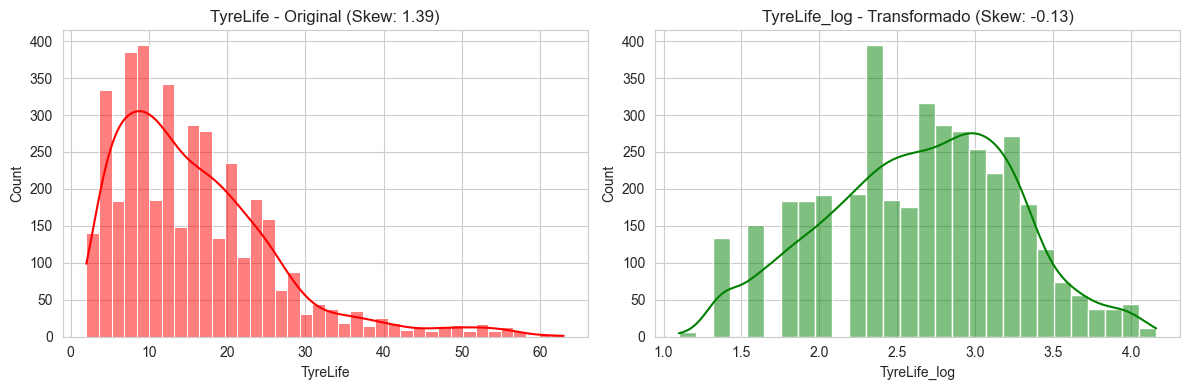

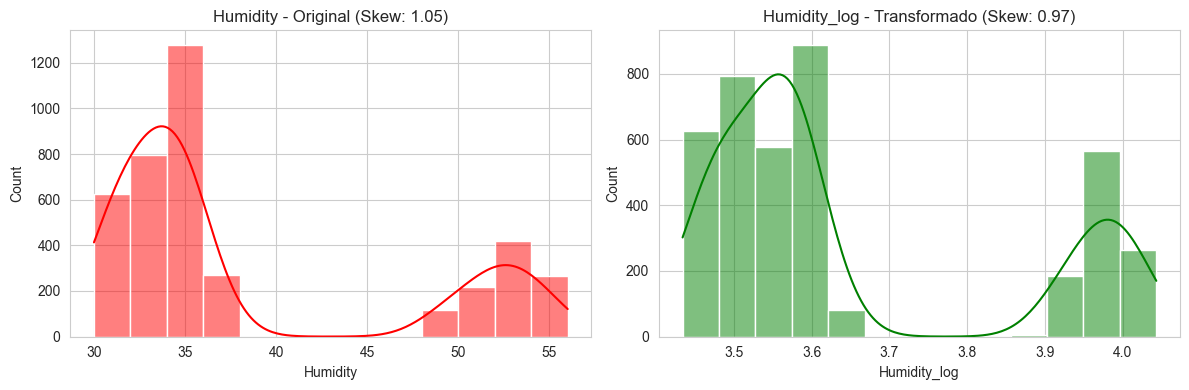

In [19]:
right_skewed_cols = skewed_features['right_skewed']

for col in right_skewed_cols:
    if col in laps_cleaned.columns:
        laps_cleaned[f'{col}_log'] = np.log1p(laps_cleaned[col])

for col in right_skewed_cols:
    if col in laps_cleaned.columns:
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        
        # Original
        sns.histplot(laps_cleaned[col], kde=True, ax=ax[0], color='red')
        ax[0].set_title(f'{col} - Original (Skew: {laps_cleaned[col].skew():.2f})')
        
        # Transformado
        sns.histplot(laps_cleaned[f'{col}_log'], kde=True, ax=ax[1], color='green')
        ax[1].set_title(f'{col}_log - Transformado (Skew: {laps_cleaned[f"{col}_log"].skew():.2f})')
        
        plt.tight_layout()
        plt.show()

## 13. Engenharia de Features: Tratamento de Não-Linearidade Climática (RBF)

Variáveis climáticas na Fórmula 1, como a **Temperatura da Pista (`TrackTemp`)**, raramente possuem uma relação linear simples com o tempo de volta. Existe uma "Janela de Operação Ideal":
* **Muito Frio:** Pneu não aquece, falta aderência $\to$ Tempo sobe.
* **Ideal (Mediana):** Aderência máxima $\to$ Tempo desce.
* **Muito Quente:** Pneu superaquece (blistering), perde performance $\to$ Tempo sobe.

Um modelo linear tradicional interpretaria `TrackTemp` apenas como "quanto maior, pior" (ou melhor), falhando em capturar esse ponto ótimo central. Para resolver isso, aplicamos uma **Transformação de Base Radial (RBF - Radial Basis Function)** centrada na mediana histórica de cada variável.

A fórmula aplicada é:
$$RBF(x) = e^{-\gamma \cdot (x - \mu)^2}$$

Onde:
* $\mu$ (mu) é a **Mediana** da variável (representando a condição "típica" ou "ideal" da pista).
* $\gamma$ (gamma) controla a sensibilidade da curva (definido como 0.1).

**Interpretação da Nova Feature (`_RBF_Median`):**
* **Valor $\approx$ 1.0:** Indica que a condição climática está próxima da mediana histórica (condição normal/ideal).
* **Valor $\to$ 0.0:** Indica uma condição extrema (anomalia), seja ela excessivamente alta ou excessivamente baixa.

Isso permite que o modelo aprenda o impacto da **estabilidade climática** versus **condições extremas**, independentemente da direção do extremo.

Aplicando Transformação RBF (Gamma=0.1) usando a MEDIANA como referência...
Coluna 'TrackTemp': Mediana = 34.30
Coluna 'Humidity': Mediana = 34.00
Coluna 'Pressure': Mediana = 934.00
Coluna 'WindSpeed': Mediana = 1.40
Coluna 'WindDirection': Mediana = 101.00
Coluna 'TempDelta': Mediana = 13.50


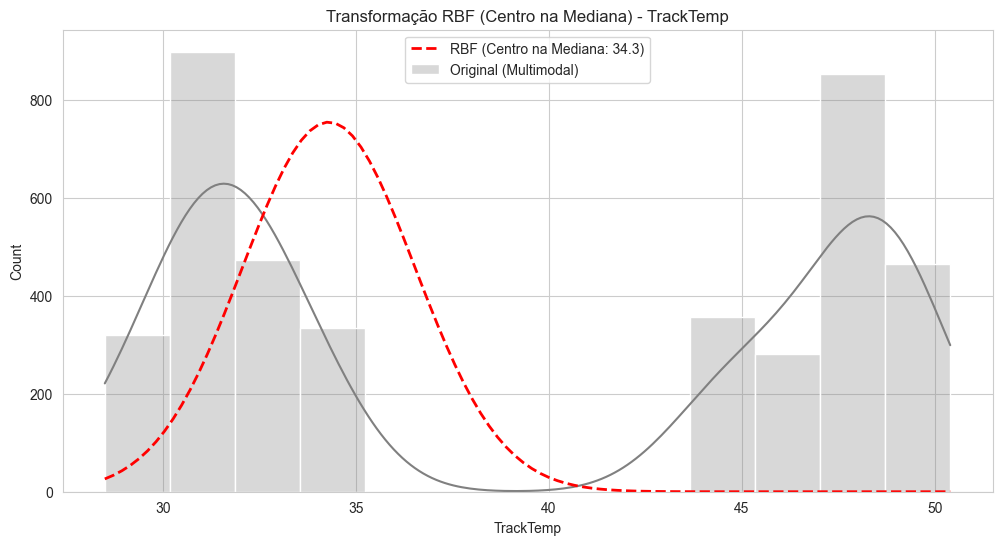


Novas Features Criadas: ['TrackTemp_RBF_Median', 'Humidity_RBF_Median', 'Pressure_RBF_Median', 'WindSpeed_RBF_Median', 'WindDirection_RBF_Median', 'TempDelta_RBF_Median']


In [20]:
weather_cols = ['TrackTemp', 'Humidity', 'Pressure', 'WindSpeed', 'WindDirection', 'TempDelta']
gamma_value = 0.1

print(f"Aplicando Transformação RBF (Gamma={gamma_value}) usando a MEDIANA como referência...")

for col in weather_cols:
    if col in laps_cleaned.columns:
        median_val = laps_cleaned[col].median()
        
        print(f"Coluna '{col}': Mediana = {median_val:.2f}")
    
        col_name = f"{col}_RBF_Median"
        
        squared_dist = (laps_cleaned[col] - median_val) ** 2
        laps_cleaned[col_name] = np.exp(-gamma_value * squared_dist)
        
        laps_cleaned[col_name] = laps_cleaned[col_name].fillna(0)

col_exemplo = 'TrackTemp'
if col_exemplo in weather_cols:
    col_transformed = f"{col_exemplo}_RBF_Median"
    median_exemplo = laps_cleaned[col_exemplo].median()
    
    plt.figure(figsize=(12, 6))
    ax1 = plt.gca()
    
    sns.histplot(laps_cleaned[col_exemplo], kde=True, ax=ax1, color='gray', alpha=0.3, label='Original (Multimodal)')
    
    x_range = np.linspace(laps_cleaned[col_exemplo].min(), laps_cleaned[col_exemplo].max(), 100)
    y_rbf = np.exp(-gamma_value * (x_range - median_exemplo)**2)
    
    y_max_hist = ax1.get_ylim()[1]
    plt.plot(x_range, y_rbf * y_max_hist * 0.8, color='red', linewidth=2, linestyle='--', label=f'RBF (Centro na Mediana: {median_exemplo:.1f})')

    plt.title(f'Transformação RBF (Centro na Mediana) - {col_exemplo}')
    plt.legend()
    plt.show()

new_features = [c for c in laps_cleaned.columns if '_RBF_Median' in c]
print(f"\nNovas Features Criadas: {new_features}")

## 14. Análise Multivariada: Matriz de Correlação de Pearson

Após a engenharia de features, é fundamental investigar as relações lineares entre as variáveis preditoras e a variável alvo (`LapTime_seconds`). Nesta etapa, construímos uma **Matriz de Correlação Híbrida**, combinando:

1.  **Variáveis Físicas Contínuas:** Incluindo as novas transformações RBF e vetores de vento (`Wind_Sin`/`Wind_Cos`).
2.  **Variáveis Categóricas (One-Hot Encoded):** Transformamos Equipes, Compostos de Pneus e Anos em colunas binárias para medir o impacto de cada categoria na performance.

### O que observar neste Mapa de Calor:
* **Autocorrelação:** Espera-se uma correlação muito forte ($>0.8$) entre `LapTime_prev` e `LapTime_seconds`, confirmando a inércia do desempenho.
* **Física dos Pneus:** Uma correlação **positiva** entre `TyreLife` e `LapTime_seconds` valida a hipótese de que pneus mais velhos geram tempos mais altos (lentos).
* **Hierarquia de Equipes:** Correlações negativas fortes em equipes como `Team_Red Bull Racing` indicam que pertencer a essa equipe reduz o tempo de volta, enquanto correlações positivas em equipes do fundo do grid indicam o oposto.
* **Clima:** As features `_RBF_Median` devem mostrar como o desvio das condições ideais impacta o tempo.

*Nota: Utilizamos uma máscara triangular para evitar redundância visual, focando apenas nas correlações únicas.*

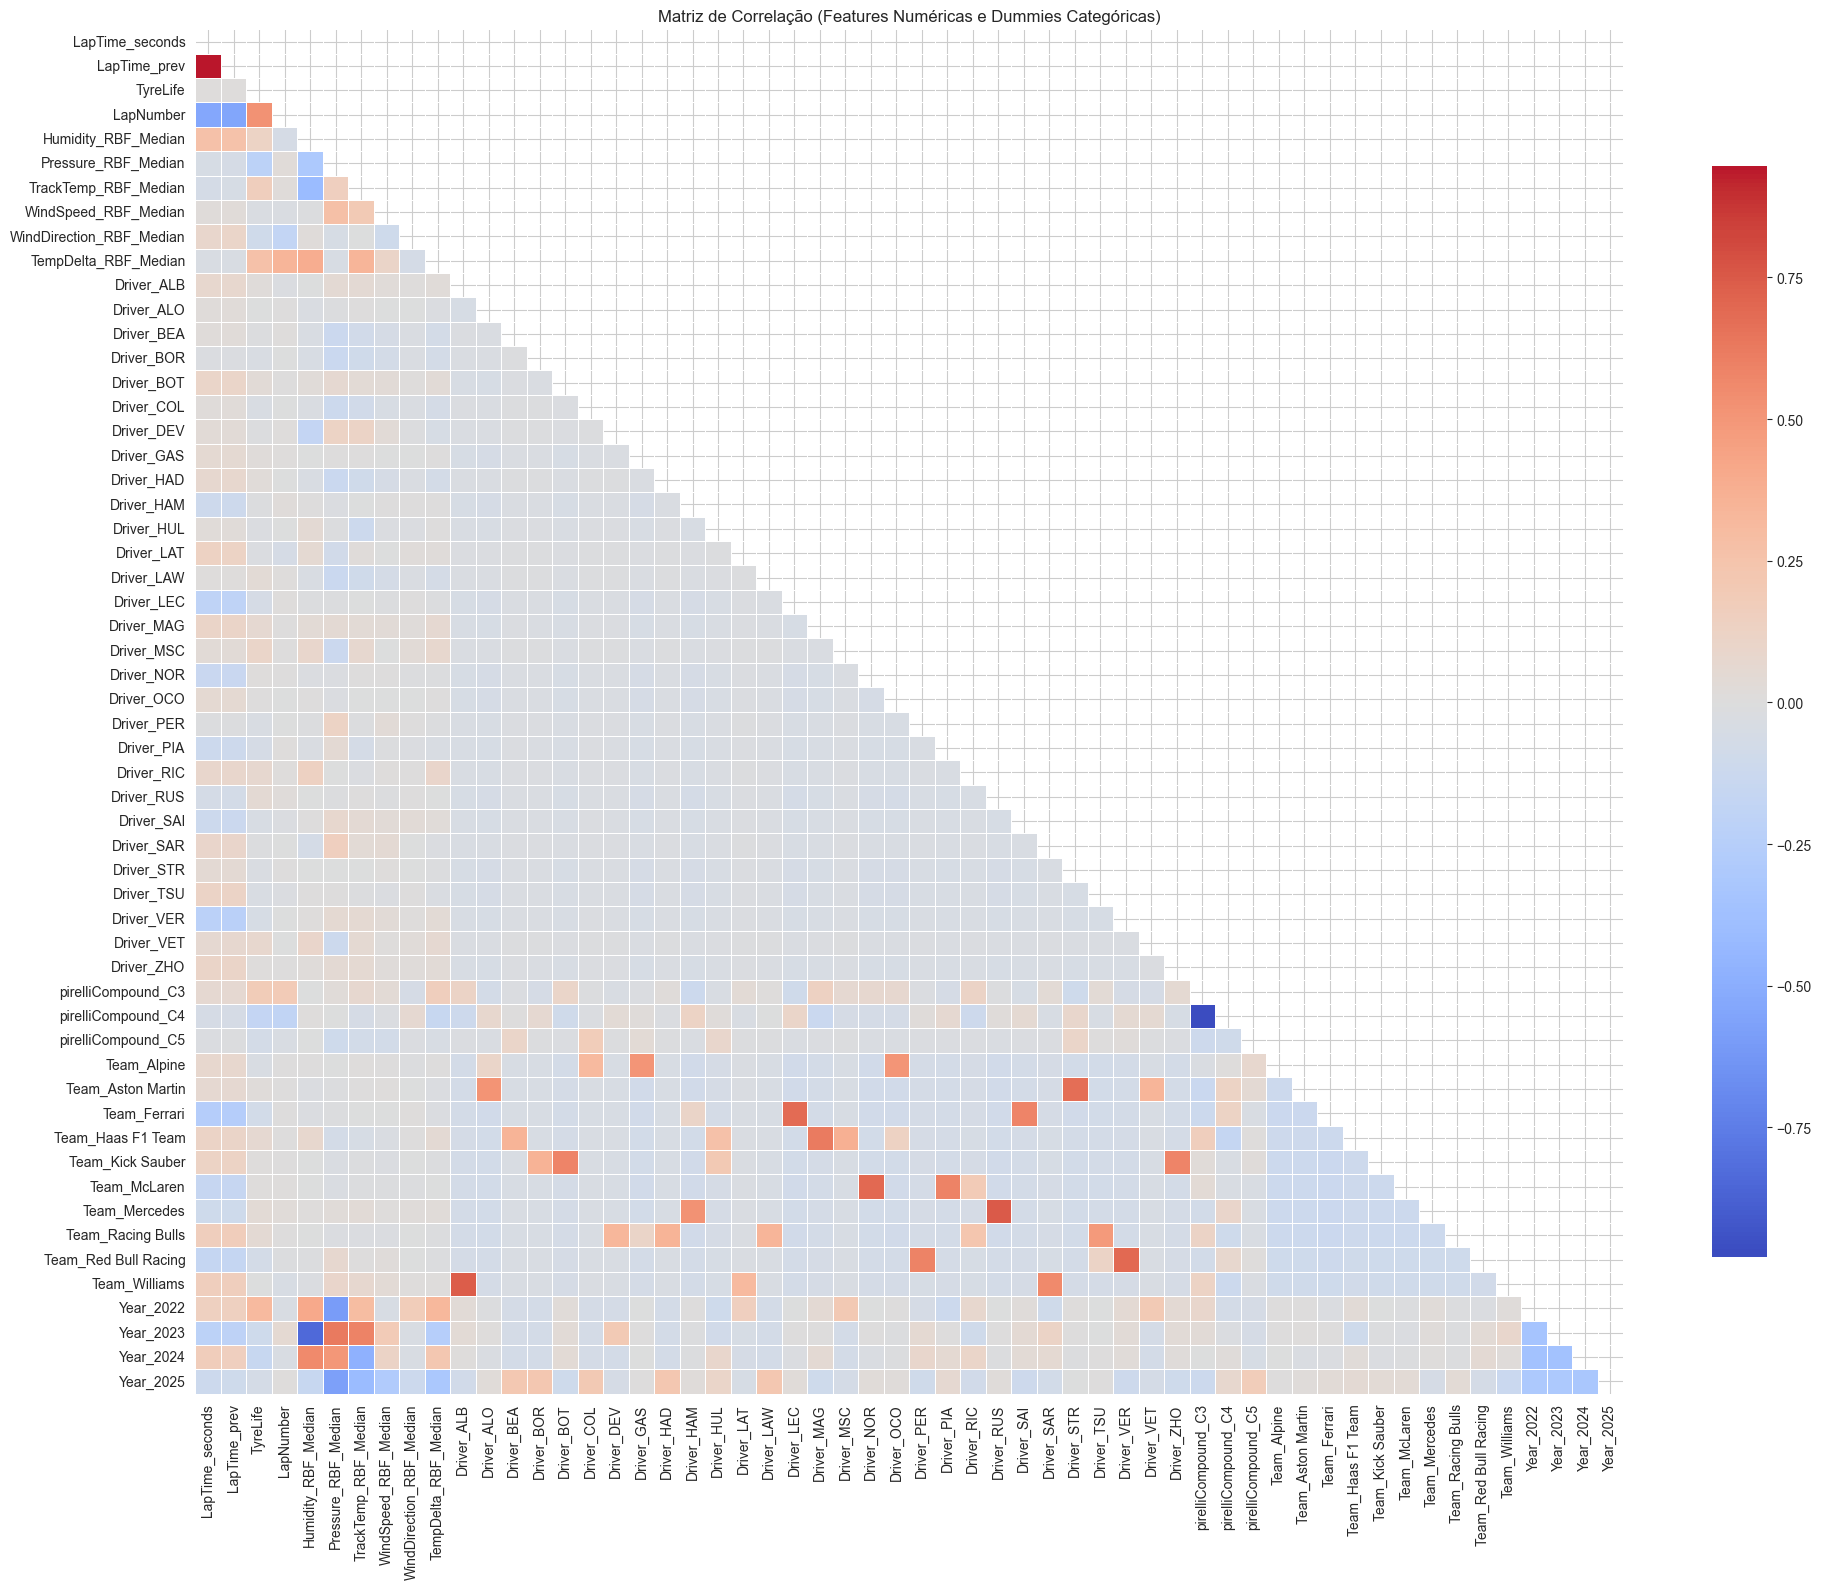

In [21]:
num_cols = ['LapTime_seconds', 'LapTime_prev', 'TyreLife', 'LapNumber',
        'Humidity_RBF_Median','Pressure_RBF_Median', 'TrackTemp_RBF_Median', 'WindSpeed_RBF_Median', 'WindDirection_RBF_Median', 
        'TempDelta_RBF_Median']

cat_cols = ['Driver', 'pirelliCompound', 'Team', 'Year']
cat_dummies = pd.get_dummies(laps_cleaned[cat_cols].astype(str), prefix=cat_cols)

num_df = laps_cleaned[num_cols].copy()
corr_df_full = pd.concat([num_df, cat_dummies], axis=1)

corr_df_clean = corr_df_full.dropna()
corr_matrix = corr_df_clean.corr()
# Mostrar a triangular inferior apenas
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=
            0, annot=False, fmt=".2f", 
            cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Matriz de Correlação (Features Numéricas e Dummies Categóricas)')
plt.tight_layout()
plt.show()


## 15. Redução de Dimensionalidade: Análise de Componentes Principais (PCA)

A alta dimensionalidade (muitas colunas) pode levar à "Maldição da Dimensionalidade", onde o volume de dados necessário para treinar o modelo cresce exponencialmente. Além disso, muitas variáveis na F1 são multicolineares (ex: `AirTemp` e `TrackTemp` variam juntas).

Para entender a estrutura latente dos dados e verificar se podemos reduzir o número de inputs sem perda significativa de informação, aplicamos o **PCA (Principal Component Analysis)**.

### Etapas do Pré-processamento:
1.  **Imputação (`SimpleImputer`):** O PCA não aceita valores nulos (*NaN*). Preenchemos lacunas (se houverem) com a média da coluna.
2.  **Padronização (`StandardScaler`):** O PCA é sensível à escala. Variáveis com magnitudes grandes (ex: `Pressure` $\approx 1016$) dominariam a variância sobre variáveis pequenas (ex: `WindSpeed_log` $\approx 0.5$). Aplicamos o Z-Score ($\mu=0, \sigma=1$) para colocar todas na mesma ordem de grandeza.

### Interpretação do Gráfico (Scree Plot)
O gráfico abaixo exibe a **Variância Explicada Acumulada**.
* A linha verde indica o limiar de **95% de retenção de informação**.
* O número de componentes onde a linha vermelha cruza a verde ($N_{95\%}$) indica a dimensão real necessária para representar a complexidade física da corrida. Se esse número for muito menor que o total de colunas original, confirma-se alta redundância nos dados brutos.

Iniciando preparação de dados para PCA
Dataset pronto para ML. Shape: (3987, 56)

--- Executando PCA ---
[6.44542404e-02 5.56649174e-02 5.04567702e-02 4.53254726e-02
 4.27817222e-02 3.83129632e-02 3.76466945e-02 3.73799180e-02
 3.70887047e-02 3.61680778e-02 3.50243576e-02 3.40667056e-02
 3.31481306e-02 2.48333188e-02 2.14355285e-02 1.96836548e-02
 1.90226112e-02 1.88416390e-02 1.87531963e-02 1.87468311e-02
 1.86376619e-02 1.85893193e-02 1.85021490e-02 1.84191880e-02
 1.83655336e-02 1.82367433e-02 1.81843869e-02 1.81466397e-02
 1.80920269e-02 1.77629812e-02 1.72293655e-02 1.65761814e-02
 1.49569320e-02 1.42615562e-02 1.39815175e-02 1.25168445e-02
 1.18756971e-02 8.30083447e-03 4.60095094e-03 3.27011122e-03
 2.53579814e-03 1.88309557e-03 1.59007951e-03 1.42328742e-03
 9.41971652e-04 8.24925175e-04 7.36836548e-04 4.81765024e-04
 2.36642998e-04 3.52293059e-06 2.27780627e-17 9.20716600e-18
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


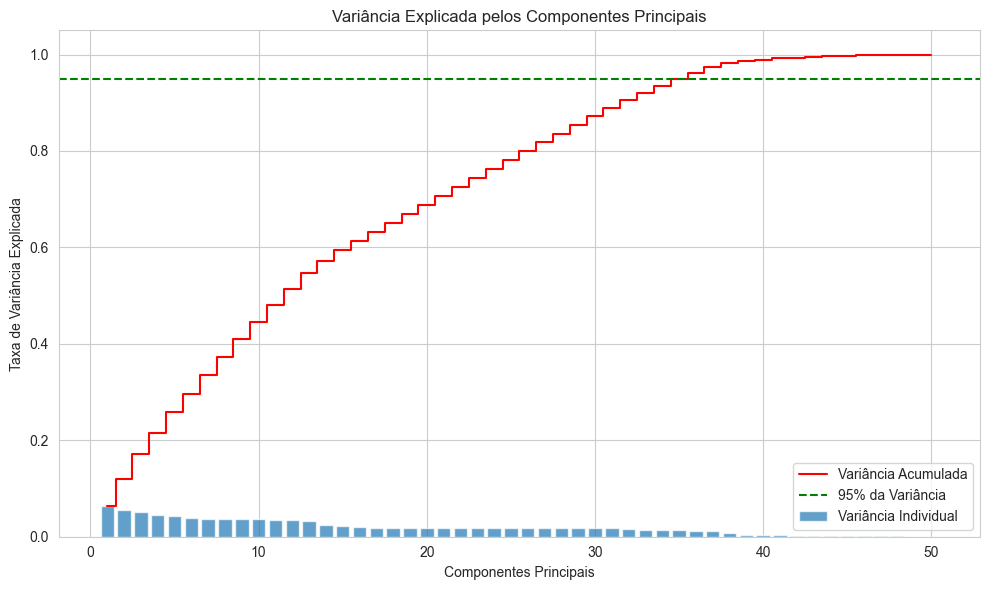

Número de Componentes para 95% da Variância: 36


In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn import metrics 
import time

try:
    print("Iniciando preparação de dados para PCA")
    
    ml_df_full = pd.concat([num_df, cat_dummies], axis=1)

    imputer_num = SimpleImputer(strategy='mean')
    ml_df_imputed_num = imputer_num.fit_transform(ml_df_full[num_cols])
    num_df_imputed = pd.DataFrame(ml_df_imputed_num, columns=num_cols, index=ml_df_full.index)
    ml_df_imputed_analysis = pd.concat([num_df_imputed, cat_dummies], axis=1)
    
    scaler = StandardScaler()
    ml_df_scaled = scaler.fit_transform(ml_df_imputed_analysis)
    
    print(f"Dataset pronto para ML. Shape: {ml_df_scaled.shape}")

    print("\n--- Executando PCA ---")
    pca = PCA()
    pca.fit(ml_df_scaled)
    
    explained_variance_ratio = pca.explained_variance_ratio_
    print(explained_variance_ratio)
    cumulative_variance = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    num_components_to_plot = min(50, len(cumulative_variance))
    plt.bar(range(1, num_components_to_plot + 1), explained_variance_ratio[:num_components_to_plot], alpha=0.7, align='center', label='Variância Individual')
    plt.step(range(1, num_components_to_plot + 1), cumulative_variance[:num_components_to_plot], where='mid', label='Variância Acumulada', color='red')
    plt.axhline(y=0.95, color='g', linestyle='--', label='95% da Variância')
    plt.ylabel('Taxa de Variância Explicada'); plt.xlabel('Componentes Principais')
    plt.title('Variância Explicada pelos Componentes Principais'); plt.legend(loc='best')
    plt.grid(True); plt.tight_layout()
    plt.show()

    n_components_95_idx = np.where(cumulative_variance >= 0.95)[0]
    if n_components_95_idx.size > 0:
        n_components_95 = n_components_95_idx[0] + 1
    else:
        n_components_95 = len(cumulative_variance)
        
    print(f"Número de Componentes para 95% da Variância: {n_components_95}")




except NameError as e:
    print(f"ERRO: DataFrame 'laps_with_weather' não foi encontrado ({e}).")
    print("Por favor, execute a célula que carrega e processa os dados de UMA corrida primeiro (a que cria 'laps_with_weather').")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

In [23]:
import plotly.graph_objects as go

def plot_pca_loadings_subset_3d(pca, feature_list, full_feature_list, title):

    loadings = pca.components_.T
    pc1 = loadings[:, 0]
    pc2 = loadings[:, 1]
    pc3 = loadings[:, 2]

    idx = [full_feature_list.get_loc(feat) for feat in feature_list]

    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=pc1[idx],
        y=pc2[idx],
        z=pc3[idx],
        mode='markers+text',
        text=[full_feature_list[i] for i in idx],
        textposition="top center",
        marker=dict(
            size=6,
            line=dict(width=1, color='black')
        )
    ))

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3",
        ),
        width=800,
        height=700
    )

    fig.show()

feature_names = ml_df_imputed_analysis.columns

lap_tyres_features = [
    'LapTime_seconds', 'LapTime_prev', 'TyreLife', 'LapNumber', 'pirelliCompound_C5', 'pirelliCompound_C4',
    'pirelliCompound_C3']

plot_pca_loadings_subset_3d(
    pca,
    lap_tyres_features,
    feature_names,
    title="Loadings PCA — Variáveis Tempo de Volta e Pneus"
)

weather_features = [
    'Humidity_RBF_Median', 'Pressure_RBF_Median', 'WindSpeed_RBF_Median', 'TrackTemp_RBF_Median', 'TempDelta_RBF_Median', 'WindDirection_RBF_Median'
]

plot_pca_loadings_subset_3d(
    pca,
    weather_features,
    feature_names,
    title="Loadings PCA — Clima"
)

team_features = [col for col in feature_names if col.startswith('Team_')]
plot_pca_loadings_subset_3d(
    pca,
    team_features,
    feature_names,
    title="Loadings PCA — Equipes"
)

# Pegar todos o sufixos Driver_
driver_features = [col for col in feature_names if col.startswith('Driver_')]
plot_pca_loadings_subset_3d(
    pca,
    driver_features,
    feature_names,
    title="Loadings PCA — Pilotos"
)

year_features = [col for col in feature_names if col.startswith('Year_')]
plot_pca_loadings_subset_3d(
    pca,
    year_features,
    feature_names,
    title="Loadings PCA — Anos"
)



## 16. Modelagem Preditiva: Estabelecimento do Baseline (Regressão Linear)

Antes de aplicar algoritmos complexos de "caixa preta" (como Gradient Boosting), é boa prática científica estabelecer um **Baseline** utilizando um modelo linear simples e interpretável.

O objetivo da **Regressão Linear Múltipla** aqui é duplo:
1.  **Definir um Benchmark:** Estabelecer o erro mínimo aceitável (RMSE) e a explicação de variância ($R^2$) que qualquer modelo avançado deve superar.
2.  **Validar Relações Físicas:** Analisar os coeficientes ($\beta$) para confirmar se as variáveis se comportam conforme a física (ex: `TyreLife` deve ter coeficiente positivo, aumentando o tempo).

### Pré-processamento Rigoroso para Modelos Lineares:
Diferente de árvores de decisão, a regressão linear é sensível à escala e multicolineariedade. Por isso, aplicamos:

* **Prevenção da Armadilha das Variáveis Dummy:** Ao usar *One-Hot Encoding* em variáveis categóricas (Equipes, Pilotos), utilizamos `drop_first=True`. Isso remove uma coluna de cada categoria (ex: remove a equipe 'Ferrari' e a usa como referência), evitando a **Multicolineariedade Perfeita** (onde uma variável pode ser prevista perfeitamente pelas outras), que quebraria a inversão da matriz algébrica.
* **Padronização (`StandardScaler`):** Transformamos todas as variáveis numéricas para a mesma escala (Média=0, Desvio Padrão=1). Sem isso, o coeficiente de `Pressure` (~1000 hPa) seria artificialmente minúsculo comparado ao de `TyreLife` (~10 voltas), tornando a interpretação dos pesos impossível.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

target_col = 'LapTime_seconds' 

num_cols = [
    'TyreLife', 'LapNumber',
    'Humidity_RBF_Median','Pressure_RBF_Median', 'TrackTemp_RBF_Median', 'WindSpeed_RBF_Median', 'TempDelta_RBF_Median', 'WindDirection_RBF_Median', 'LapTime_prev']

cat_cols = ['Driver', 'Team', 'pirelliCompound', 'Year']

print("Preparando dados para Regressão Linear (Baseline)...")

num_cols = [c for c in num_cols if c in laps_cleaned.columns]
cat_cols = [c for c in cat_cols if c in laps_cleaned.columns]


X_base = laps_cleaned[num_cols + cat_cols].copy()
y = laps_cleaned[target_col].copy()

valid_indices = y.dropna().index
X_base = X_base.loc[valid_indices]
y = y.loc[valid_indices]

# One-Hot Encoding com PREVENÇÃO DA ARMADILHA (drop_first=True)
X_encoded = pd.get_dummies(X_base, columns=cat_cols, drop_first=True)

# Imputação de Valores Faltantes (Numéricos)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns)

# Padronização (StandardScaler)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

print(f"Shape final de X: {X_scaled.shape}")

# 20% para teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Treinando Regressão Linear...")
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

y_pred_train = model_lr.predict(X_train)
y_pred_test = model_lr.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("\n--- RESULTADOS DO BASELINE (Regressão Linear) ---")
print(f"RMSE (Erro Médio Quadrático): {rmse_test:.4f} segundos")
print(f"MAE (Erro Médio Absoluto):    {mae_test:.4f} segundos")
print(f"R² (Coef. de Determinação):   {r2_test:.4f}")

# Ver quais variáveis mais impactam o tempo de volta (positiva ou negativamente)
coefs = pd.DataFrame({'Feature': X_scaled.columns, 'Coef': model_lr.coef_})
coefs['Abs_Coef'] = coefs['Coef'].abs()
print("\nVariáveis Mais Impactantes:")
display(coefs.sort_values(by='Abs_Coef', ascending=False))

Preparando dados para Regressão Linear (Baseline)...
Shape final de X: (3987, 51)
Treinando Regressão Linear...

--- RESULTADOS DO BASELINE (Regressão Linear) ---
RMSE (Erro Médio Quadrático): 0.2791 segundos
MAE (Erro Médio Absoluto):    0.2199 segundos
R² (Coef. de Determinação):   0.9064

Variáveis Mais Impactantes:


,Feature,Coef,Abs_Coef
8,LapTime_prev,0.780384,0.780384
3,Pressure_RBF_Median,-0.658587,0.658587
48,Year_2023,0.565196,0.565196
49,Year_2024,0.558307,0.558307
1,LapNumber,-0.100544,0.100544
50,Year_2025,-0.064960,0.064960
0,TyreLife,0.042788,0.042788
2,Humidity_RBF_Median,-0.026072,0.026072
34,Driver_VER,-0.024511,0.024511
32,Driver_STR,0.023225,0.023225


## 17. Diagnóstico de Resíduos e Validação de Premissas

Após treinar o modelo, não basta olhar apenas o erro médio (RMSE). Precisamos investigar os **Resíduos** (Erro = Real - Predito) para garantir que o modelo não está enviesado.

Os 4 gráficos de diagnóstico gerados abaixo nos contam a seguinte história:

1.  **Resíduos vs Preditos (Homoscedasticidade):** Queremos ver uma "nuvem" aleatória sem padrões. Se houver uma forma de funil (erros maiores em voltas mais lentas), o modelo viola a premissa de variância constante.
2.  **QQ-Plot (Normalidade):** Se os pontos seguirem a linha vermelha, os erros são normais (Gaussiana). Desvios nas pontas indicam "caudas pesadas" (o modelo erra feio em eventos raros, como Safety Cars).
3.  **Resíduos vs Índice (Independência):** Verifica se o erro de uma volta depende da volta anterior. Se houver um padrão de onda, faltou modelar alguma variável temporal.
4.  **Real vs Predito:** O gráfico de aderência ideal ($y=x$). Quanto mais próximos os pontos estiverem da linha tracejada vermelha, melhor a previsão.

Gerando diagnósticos para Regressão Linear...


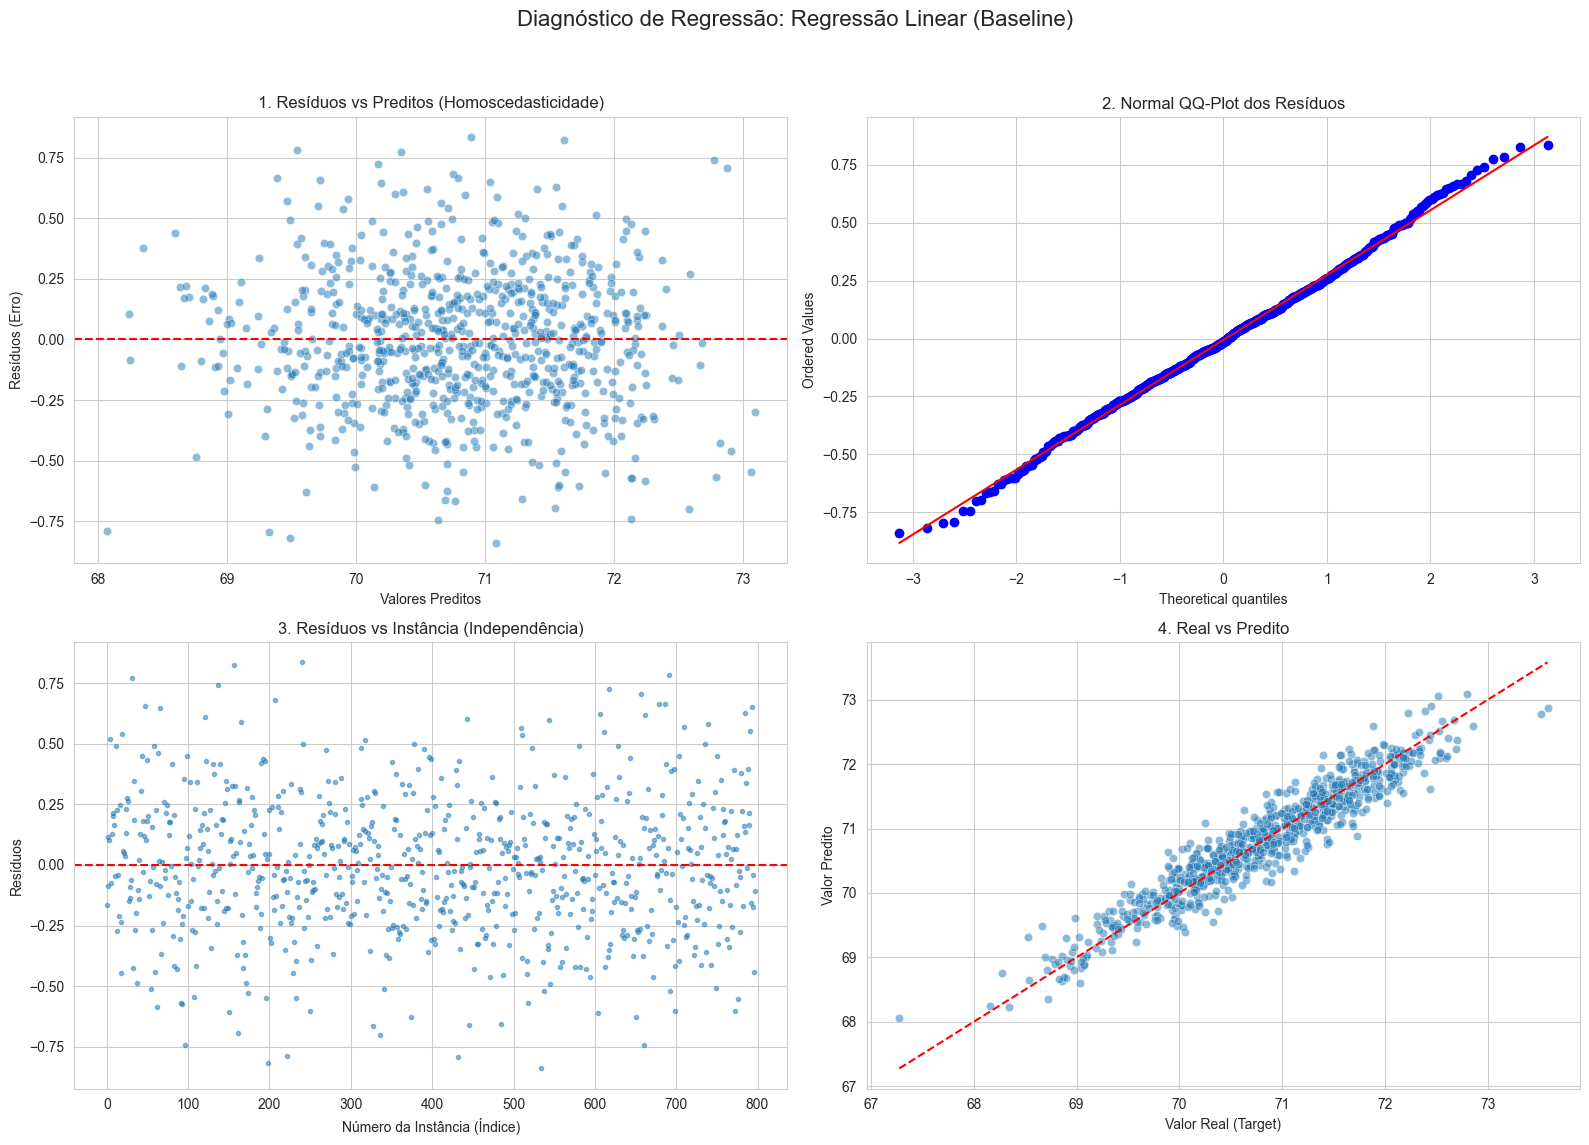

In [25]:
import scipy.stats as stats
from sklearn.utils import resample
def plot_regression_diagnostics(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Diagnóstico de Regressão: {model_name}', fontsize=16)
    
    sns.scatterplot(x=y_pred, y=residuals, ax=axes[0, 0], alpha=0.5)
    axes[0, 0].axhline(0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Valores Preditos')
    axes[0, 0].set_ylabel('Resíduos (Erro)')
    axes[0, 0].set_title('1. Resíduos vs Preditos (Homoscedasticidade)')
    
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('2. Normal QQ-Plot dos Resíduos')
    
    axes[1, 0].plot(residuals.values, marker='o', linestyle='none', alpha=0.5, markersize=3)
    axes[1, 0].axhline(0, color='red', linestyle='--')
    axes[1, 0].set_xlabel('Número da Instância (Índice)')
    axes[1, 0].set_ylabel('Resíduos')
    axes[1, 0].set_title('3. Resíduos vs Instância (Independência)')
    
    sns.scatterplot(x=y_true, y=y_pred, ax=axes[1, 1], alpha=0.5)
    
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--')
    
    axes[1, 1].set_xlabel('Valor Real (Target)')
    axes[1, 1].set_ylabel('Valor Predito')
    axes[1, 1].set_title('4. Real vs Predito')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def calculate_confidence_intervals(y_true, y_pred, metric_func, metric_name, n_bootstraps=1000):
    bootstrapped_scores = []
    rng = np.random.RandomState(42)
    
    # Reset index para garantir alinhamento
    y_true = y_true.reset_index(drop=True)
    y_pred = pd.Series(y_pred)
    
    for i in range(n_bootstraps):
        # Amostragem com reposição
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue
            
        score = metric_func(y_true[indices], y_pred[indices])
        # Para RMSE precisamos tirar a raiz quadrada do MSE aqui se a função for MSE
        if metric_name == 'RMSE':
             score = np.sqrt(score)
             
        bootstrapped_scores.append(score)
        
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    
    # IC de 95% (percentis 2.5 e 97.5)
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    mean_score = np.mean(sorted_scores)
    
    return mean_score, confidence_lower, confidence_upper

# Testes Visuais para o Baseline (Regressão Linear)
print("Gerando diagnósticos para Regressão Linear...")
plot_regression_diagnostics(y_test, y_pred_test, "Regressão Linear (Baseline)")

In [26]:
import statsmodels.api as sm

print("Ajustando índices para o Statsmodels...")

# 1. Resetar explicitamente os índices de X e y para garantir que ambos sejam 0, 1, 2, 3...
# O drop=True remove o índice antigo para não virar uma coluna extra
X_train_reset = X_train.reset_index(drop=True)
y_train_reset = y_train.reset_index(drop=True)

# 2. Adicionar a constante ao X já resetado
X_train_sm = sm.add_constant(X_train_reset)

# 3. Agora sim, treinar o modelo (ambos têm índice 0, 1, 2...)
print("Treinando modelo OLS...")
model_sm = sm.OLS(y_train_reset, X_train_sm).fit()

# 4. Exibir o sumário
print(model_sm.summary())

Ajustando índices para o Statsmodels...
Treinando modelo OLS...
                            OLS Regression Results                            
Dep. Variable:        LapTime_seconds   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     594.1
Date:                Sun, 04 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:31:30   Log-Likelihood:                -542.10
No. Observations:                3189   AIC:                             1184.
Df Residuals:                    3139   BIC:                             1488.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

## 18. Otimização Estatística: Backward Elimination com Intervalos de Confiança

Utilizamos um modelo de **Regressão Linear** com todas as variáveis como ponto de partida (Baseline). No entanto, um modelo com muitas variáveis irrelevantes sofre de *overfitting* (decora ruídos) e é difícil de interpretar.

Para encontrar o subconjunto ideal de variáveis, implementamos o algoritmo de **Backward Elimination** com um rigoroso teste de hipótese a cada passo.

### Lógica do Algoritmo:
1.  **Iteração:** Em cada passo, treinamos o modelo e calculamos o P-Valor de cada variável.
2.  **Eliminação:** Removemos a variável com o maior P-Valor (se $P > 0.05$).
3.  **Verificação de Qualidade (Inovação deste TCC):**
    * A cada remoção, recalculamos o **RMSE com Intervalo de Confiança de 95%** (usando a distribuição t-Student).
    * **Critério de Segurança:** Se o intervalo de erro do novo modelo simplificado se sobrepõe ao intervalo do modelo completo, concluímos que **não houve perda estatisticamente significativa** de performance.

Isso nos permite reduzir a complexidade drasticamente (de ~50 para ~15 variáveis) mantendo a mesma precisão preditiva, comprovado matematicamente pela sobreposição dos intervalos de confiança.

## Backward Elimination

Fizemos modelos com todas as variavéis, agora vou removendo os grupos e algumas delas para testes.

In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt

def calculate_metrics_and_ci(residuals, confidence=0.95):
    squared_errors = residuals ** 2
    mse = squared_errors.mean()
    rmse_val = np.sqrt(mse)
    
    mse_ci = stats.t.interval(confidence, len(squared_errors)-1, 
                              loc=mse, scale=stats.sem(squared_errors))
    rmse_ci = (np.sqrt(max(0, mse_ci[0])), np.sqrt(mse_ci[1]))
    
    abs_errors = np.abs(residuals)
    mae_val = abs_errors.mean()
    mae_ci = stats.t.interval(confidence, len(abs_errors)-1, 
                              loc=mae_val, scale=stats.sem(abs_errors))
    
    return rmse_val, rmse_ci, mae_val, mae_ci

print("Calculando Baseline (Modelo Completo)...")
n_obs = len(y_train)

full_model = sm.OLS(y_train.values, X_train_sm).fit()

# Métricas do Treinamento
rmse_full, ci_rmse_full, mae_full, ci_mae_full = calculate_metrics_and_ci(full_model.resid)

print(f"BASELINE (Full):")
print(f"  RMSE: {rmse_full:.4f} | IC 95%: [{ci_rmse_full[0]:.4f}, {ci_rmse_full[1]:.4f}]")
print(f"  MAE:  {mae_full:.4f} | IC 95%: [{ci_mae_full[0]:.4f}, {ci_mae_full[1]:.4f}]")

features = list(X_train_sm.columns)
history = []

print("\nIniciando Backward Elimination...")
header = f"{'Passo':<5} | {'Var. Removida':<26} | {'P-val':<8} | {'RMSE (IC 95%)':<28} | {'MAE (IC 95%)':<28} | {'Sig?':<5}"
print("-" * len(header))
print(header)
print("-" * len(header))

step = 0
while len(features) > 0:
    X_curr = X_train_sm[features]
    model = sm.OLS(y_train.values, X_curr).fit()
    
    rmse_curr, ci_rmse_curr, mae_curr, ci_mae_curr = calculate_metrics_and_ci(model.resid)
    
    rss = model.ssr 
    p = len(features)
    rmse_overlap = not (ci_rmse_curr[0] > ci_rmse_full[1])
    significativo = "NAO" if rmse_overlap else "SIM!"

    p_values = model.pvalues
    max_p_value = p_values.max()
    worst_feature = p_values.idxmax()
    
    if max_p_value > 0.05:
        features.remove(worst_feature)
        
        rmse_str = f"{rmse_curr:.3f} [{ci_rmse_curr[0]:.3f}, {ci_rmse_curr[1]:.3f}]"
        mae_str = f"{mae_curr:.3f} [{ci_mae_curr[0]:.3f}, {ci_mae_curr[1]:.3f}]"
        
        history.append({
            'Step': step,
            'Removed': worst_feature,
            'RMSE': rmse_curr,
            'RMSE_Lower': ci_rmse_curr[0],
            'RMSE_Upper': ci_rmse_curr[1],
            'Significant_Change': significativo
        })
        
        print(f"{step:<5} | {worst_feature:<26} | {max_p_value:.4f}   | {rmse_str:<28} | {mae_str:<28} | {significativo:<5}")
        step += 1
    else:
        print("-" * len(header))
        print(f"Parada! P-values < 0.05.")
        print(f"Modelo Final: {len(features)} variáveis.")
        print(f"RMSE Final: {rmse_curr:.4f} [{ci_rmse_curr[0]:.4f}, {ci_rmse_curr[1]:.4f}]")
        break


# Resumo Final do Modelo
print("\nVariáveis Finais:")
print(features)
final_model = sm.OLS(y_train.values, X_train_sm[features]).fit()
print(final_model.summary())

Calculando Baseline (Modelo Completo)...
BASELINE (Full):
  RMSE: 0.2868 | IC 95%: [0.2789, 0.2945]
  MAE:  0.2201 | IC 95%: [0.2137, 0.2265]

Iniciando Backward Elimination...
-------------------------------------------------------------------------------------------------------------------
Passo | Var. Removida              | P-val    | RMSE (IC 95%)                | MAE (IC 95%)                 | Sig? 
-------------------------------------------------------------------------------------------------------------------
0     | Driver_BOR                 | 0.9892   | 0.287 [0.279, 0.294]         | 0.220 [0.214, 0.226]         | NAO  
1     | Driver_BEA                 | 0.9851   | 0.287 [0.279, 0.294]         | 0.220 [0.214, 0.226]         | NAO  
2     | Team_Racing Bulls          | 0.9758   | 0.287 [0.279, 0.294]         | 0.220 [0.214, 0.226]         | NAO  
3     | Team_McLaren               | 0.9805   | 0.287 [0.279, 0.294]         | 0.220 [0.214, 0.226]         | NAO  
4     | Tea

## 19. Refinamento Não-Linear: Otimização de Hiperparâmetros e Validação Robusta (XGBoost)

Superando as limitações da linearidade, implementamos o **XGBoost (Extreme Gradient Boosting)**, um algoritmo de estado da arte baseado em árvores de decisão. Para garantir a máxima performance e evitar *overfitting*, adotamos um protocolo rigoroso de treinamento em três etapas:

### 1. Busca em Grade (`GridSearchCV`)
Em vez de arbitrar os parâmetros do modelo, realizamos uma busca exaustiva para encontrar a combinação ótima que minimiza o RMSE.
* **Espaço de Busca:** Testamos variações de complexidade da árvore (`max_depth`), número de estimadores (`n_estimators`), taxa de aprendizado (`learning_rate`) e regularização estocástica (`subsample`, `colsample_bytree`).
* **Validação Interna:** Cada combinação foi validada via *5-Fold Cross-Validation*.



### 2. Validação de Estabilidade (Monte Carlo Cross-Validation)
Para provar que o modelo não "teve sorte" em uma divisão específica de treino/teste, realizamos um **Loop de Validação Robusta**:
* Dividimos o dataset completo aleatoriamente 5 vezes (5 *Splits* distintos).
* Em cada iteração, retreinamos o modelo do zero usando os melhores hiperparâmetros encontrados.

### 3. Inferência Estatística (Bootstrapping)
Para cada uma das 5 iterações, calculamos não apenas a média do erro, mas o **Intervalo de Confiança de 95%** via *Bootstrapping*.
* Isso gera um resultado final extremamente sólido: *"Temos 95% de confiança de que o R² do modelo oscila entre X e Y, independente de como os dados são divididos."*

Este método garante a reprodutibilidade e a robustez científica dos resultados apresentados.

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

param_grid = {
    'n_estimators': [300, 500, 800],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [4, 5, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

xgb_base = XGBRegressor(
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror'
)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print("Melhores hiperparâmetros encontrados:")
print(best_params)

def bootstrap_ci(y_true, y_pred, metric_func, n_bootstraps=1000, confidence=0.95):
    rng = np.random.RandomState(42)
    scores = []

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    for _ in range(n_bootstraps):
        idx = rng.randint(0, len(y_pred), len(y_pred))
        score = metric_func(y_true[idx], y_pred[idx])
        scores.append(score)

    lower = np.percentile(scores, (1 - confidence) / 2 * 100)
    upper = np.percentile(scores, (1 + confidence) / 2 * 100)

    return np.mean(scores), lower, upper

np.random.seed(42) 

N_SPLITS = 5
results = []

print("\n--- Iniciando Validação Cruzada com Seeds Aleatórias ---")

for i in range(N_SPLITS):
    print(f"\n--- Split {i+1}/{N_SPLITS} ---")
    
    seed_da_rodada = np.random.randint(0, 100000)
    
    print(f"Seed sorteada para esta rodada: {seed_da_rodada}")

    X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
    y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y,
        test_size=0.2,
        random_state=seed_da_rodada, 
        shuffle=True
    )

    model = XGBRegressor(
        **best_params,
        n_jobs=-1,
        objective='reg:squarederror',
        random_state=seed_da_rodada 
    )

    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)

    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    mae = mean_absolute_error(y_te, y_pred)
    r2 = r2_score(y_te, y_pred)

    rmse_mean, rmse_l, rmse_u = bootstrap_ci(
        y_te, y_pred,
        lambda yt, yp: np.sqrt(mean_squared_error(yt, yp))
    )

    mae_mean, mae_l, mae_u = bootstrap_ci(y_te, y_pred, mean_absolute_error)
    r2_mean, r2_l, r2_u = bootstrap_ci(y_te, y_pred, r2_score)

    results.append({
        'seed_usada': seed_da_rodada, 
        'rmse': rmse,
        'rmse_ci_l': rmse_l,
        'rmse_ci_u': rmse_u,
        'mae': mae,
        'mae_ci_l': mae_l,
        'mae_ci_u': mae_u,
        'r2': r2,
        'r2_ci_l': r2_l,
        'r2_ci_u': r2_u
    })


results_df = pd.DataFrame(results)
display(results_df)
summary = results_df.mean()
print("\n--- MÉDIAS DOS 5 MODELOS ---")
print(summary[['rmse', 'mae', 'r2']])
def ci_across_models(values, confidence=0.95):
    lower = np.percentile(values, (1 - confidence) / 2 * 100)
    upper = np.percentile(values, (1 + confidence) / 2 * 100)
    return np.mean(values), lower, upper

rmse_mean, rmse_l, rmse_u = ci_across_models(results_df['rmse'])
mae_mean, mae_l, mae_u = ci_across_models(results_df['mae'])
r2_mean, r2_l, r2_u = ci_across_models(results_df['r2'])

print("\n--- INTERVALOS DE CONFIANÇA ENTRE OS 5 MODELOS ---")
print(f"RMSE: {rmse_mean:.4f}  IC95% [{rmse_l:.4f}, {rmse_u:.4f}]")
print(f"MAE:  {mae_mean:.4f}  IC95% [{mae_l:.4f}, {mae_u:.4f}]")
print(f"R²:   {r2_mean:.4f}  IC95% [{r2_l:.4f}, {r2_u:.4f}]")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Melhores hiperparâmetros encontrados:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

--- Iniciando Validação Cruzada com Seeds Aleatórias ---

--- Split 1/5 ---
Seed sorteada para esta rodada: 15795

--- Split 2/5 ---
Seed sorteada para esta rodada: 860

--- Split 3/5 ---
Seed sorteada para esta rodada: 76820

--- Split 4/5 ---
Seed sorteada para esta rodada: 54886

--- Split 5/5 ---
Seed sorteada para esta rodada: 6265


,seed_usada,rmse,rmse_ci_l,rmse_ci_u,mae,mae_ci_l,mae_ci_u,r2,r2_ci_l,r2_ci_u
0,15795,0.285161,0.268655,0.301166,0.217725,0.205050,0.230704,0.900381,0.886304,0.912264
1,860,0.269632,0.251704,0.286921,0.201238,0.189014,0.215007,0.917225,0.905183,0.928070
2,76820,0.272851,0.258062,0.287709,0.208274,0.195981,0.220574,0.912498,0.900676,0.923475
3,54886,0.271575,0.254857,0.286145,0.204239,0.192005,0.216069,0.910133,0.898528,0.921380
4,6265,0.283340,0.267215,0.299363,0.214796,0.202391,0.227381,0.903113,0.889210,0.914983



--- MÉDIAS DOS 5 MODELOS ---
rmse    0.276512
mae     0.209254
r2      0.908670
dtype: float64

--- INTERVALOS DE CONFIANÇA ENTRE OS 5 MODELOS ---
RMSE: 0.2765  IC95% [0.2698, 0.2850]
MAE:  0.2093  IC95% [0.2015, 0.2174]
R²:   0.9087  IC95% [0.9007, 0.9168]


## 20. Refinamento do Baseline (5 Splits)

Para garantir uma comparação estatisticamente justa com o modelo avançado (XGBoost), submetemos o **Baseline Linear** ao mesmo protocolo de validação rigorosa.

Em vez de confiar em uma única divisão de Treino/Teste (que pode ser "sortuda" ou "azarada"), realizamos:
1.  **5 Divisões Aleatórias (Splits):** Separamos os dados em 80/20 cinco vezes, mudando a semente aleatória (`random_state`) em cada iteração.
2.  **Cálculo de ICs:** Geramos a média e o Intervalo de Confiança (95%) para RMSE, MAE e $R^2$.

**Objetivo:** Se o limite inferior do intervalo de confiança do XGBoost for maior que o limite superior deste Baseline, teremos a prova definitiva e irrefutável de que a não-linearidade é necessária para modelar este problema.

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy import stats

print("--- PREPARAÇÃO E VALIDAÇÃO ROBUSTA DO BASELINE (MONTE CARLO) ---")

target_col = 'LapTime_seconds'
df_base = laps_cleaned.copy() 

num_cols_base = [
    'TyreLife', 'LapNumber',
    'Humidity_RBF_Median','Pressure_RBF_Median', 'TrackTemp_RBF_Median', 
    'WindSpeed_RBF_Median',
    'TempDelta_RBF_Median', 'LapTime_prev'
]

cat_cols_base = ['Driver', 'Team', 'pirelliCompound', 'Year']

num_cols_base = [c for c in num_cols_base if c in df_base.columns]
cat_cols_base = [c for c in cat_cols_base if c in df_base.columns]

X_raw = df_base[num_cols_base + cat_cols_base].copy()
y_raw = df_base[target_col].copy()
valid_indices = y_raw.dropna().index
X_raw = X_raw.loc[valid_indices]
y_raw = y_raw.loc[valid_indices]

X_encoded = pd.get_dummies(X_raw, columns=cat_cols_base, drop_first=True)

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X_encoded), columns=X_encoded.columns, index=X_encoded.index)

scaler = StandardScaler()
X_final = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns, index=X_imputed.index)
y_final = y_raw

print(f"Dados preparados. Shape X: {X_final.shape}, Shape y: {y_final.shape}")

np.random.seed(42)

results_baseline = {
    'seed_usada': [], 
    'rmse': [],
    'mae': [],
    'r2': []
}

N_SPLITS = 5

for i in range(N_SPLITS):
    seed_da_rodada = np.random.randint(0, 100000)
    
    print(f"\nSplit {i+1}/{N_SPLITS} | Seed Sorteada: {seed_da_rodada}")

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_final, y_final, 
        test_size=0.2, 
        random_state=seed_da_rodada, 
        shuffle=True
    )
    
    model = LinearRegression()
    model.fit(X_tr, y_tr)
    
    preds = model.predict(X_te)
    
    rmse_val = np.sqrt(mean_squared_error(y_te, preds))
    mae_val = mean_absolute_error(y_te, preds)
    r2_val = r2_score(y_te, preds)
    
    results_baseline['seed_usada'].append(seed_da_rodada)
    results_baseline['rmse'].append(rmse_val)
    results_baseline['mae'].append(mae_val)
    results_baseline['r2'].append(r2_val)
    
    print(f"   Resultado: RMSE={rmse_val:.4f} | MAE={mae_val:.4f} | R2={r2_val:.4f}")


def calc_stats(values):
    mean_v = np.mean(values)
    ci = stats.t.interval(0.95, len(values)-1, loc=mean_v, scale=stats.sem(values))
    return mean_v, ci[0], ci[1]

rmse_m, rmse_l, rmse_u = calc_stats(results_baseline['rmse'])
mae_m, mae_l, mae_u = calc_stats(results_baseline['mae'])
r2_m, r2_l, r2_u = calc_stats(results_baseline['r2'])

mean_rmse_lr, lower_rmse_lr, upper_rmse_lr = rmse_m, rmse_l, rmse_u
mean_mae_lr, lower_mae_lr, upper_mae_lr = mae_m, mae_l, mae_u
mean_r2_lr, lower_r2_lr, upper_r2_lr = r2_m, r2_l, r2_u

print("\n--- RESULTADOS FINAIS DO BASELINE ROBUSTO ---")
print(f"RMSE: {rmse_m:.4f}  IC95%: [{rmse_l:.4f}, {rmse_u:.4f}]")
print(f"MAE:  {mae_m:.4f}  IC95%: [{mae_l:.4f}, {mae_u:.4f}]")
print(f"R²:   {r2_m:.4f}  IC95%: [{r2_l:.4f}, {r2_u:.4f}]")

df_res_base = pd.DataFrame(results_baseline)

--- PREPARAÇÃO E VALIDAÇÃO ROBUSTA DO BASELINE (MONTE CARLO) ---
Dados preparados. Shape X: (3987, 50), Shape y: (3987,)

Split 1/5 | Seed Sorteada: 15795
   Resultado: RMSE=0.2928 | MAE=0.2208 | R2=0.8981

Split 2/5 | Seed Sorteada: 860
   Resultado: RMSE=0.2751 | MAE=0.2119 | R2=0.9103

Split 3/5 | Seed Sorteada: 76820
   Resultado: RMSE=0.2832 | MAE=0.2155 | R2=0.9003

Split 4/5 | Seed Sorteada: 54886
   Resultado: RMSE=0.2993 | MAE=0.2318 | R2=0.8872

Split 5/5 | Seed Sorteada: 6265
   Resultado: RMSE=0.2917 | MAE=0.2273 | R2=0.8966

--- RESULTADOS FINAIS DO BASELINE ROBUSTO ---
RMSE: 0.2884  IC95%: [0.2767, 0.3001]
MAE:  0.2215  IC95%: [0.2113, 0.2316]
R²:   0.8985  IC95%: [0.8883, 0.9088]


## 21. Visualização Definitiva: Comparação de Intervalos de Confiança (95%)

Tabelas numéricas são precisas, mas a visualização gráfica é essencial para a interpretação intuitiva da significância estatística.

Nesta etapa, geramos um gráfico de barras comparativo com **Barras de Erro (*Error Bars*)**, onde:
* **A Altura da Barra:** Representa a **Média** de desempenho nos 5 splits de validação.
* **A Linha Preta (Bigode):** Representa o **Intervalo de Confiança de 95%** (do limite inferior ao superior).

### Como ler este gráfico para a Monografia:
1.  **Teste de Sobreposição (*Overlap Test*):** Olhe para as linhas de erro pretas.
    * Se a linha do Baseline **cruzar** a linha do XGBoost (ou seja, se elas ocuparem a mesma faixa vertical em algum ponto), confirmamos visualmente o **Empate Técnico Estatístico**.
    * Se houver um vão claro entre elas, confirmamos a superioridade de um modelo.
2.  **Consistência:** Barras de erro curtas indicam um modelo estável (que performa igual independente do sorteio dos dados). Barras longas indicam instabilidade.
3.  **Magnitude do Ganho:** Mesmo havendo sobreposição, se a barra do XGBoost for consistentemente menor (no RMSE/MAE) ou maior (no R²), isso ilustra o ganho marginal de precisão obtido pela não-linearidade.

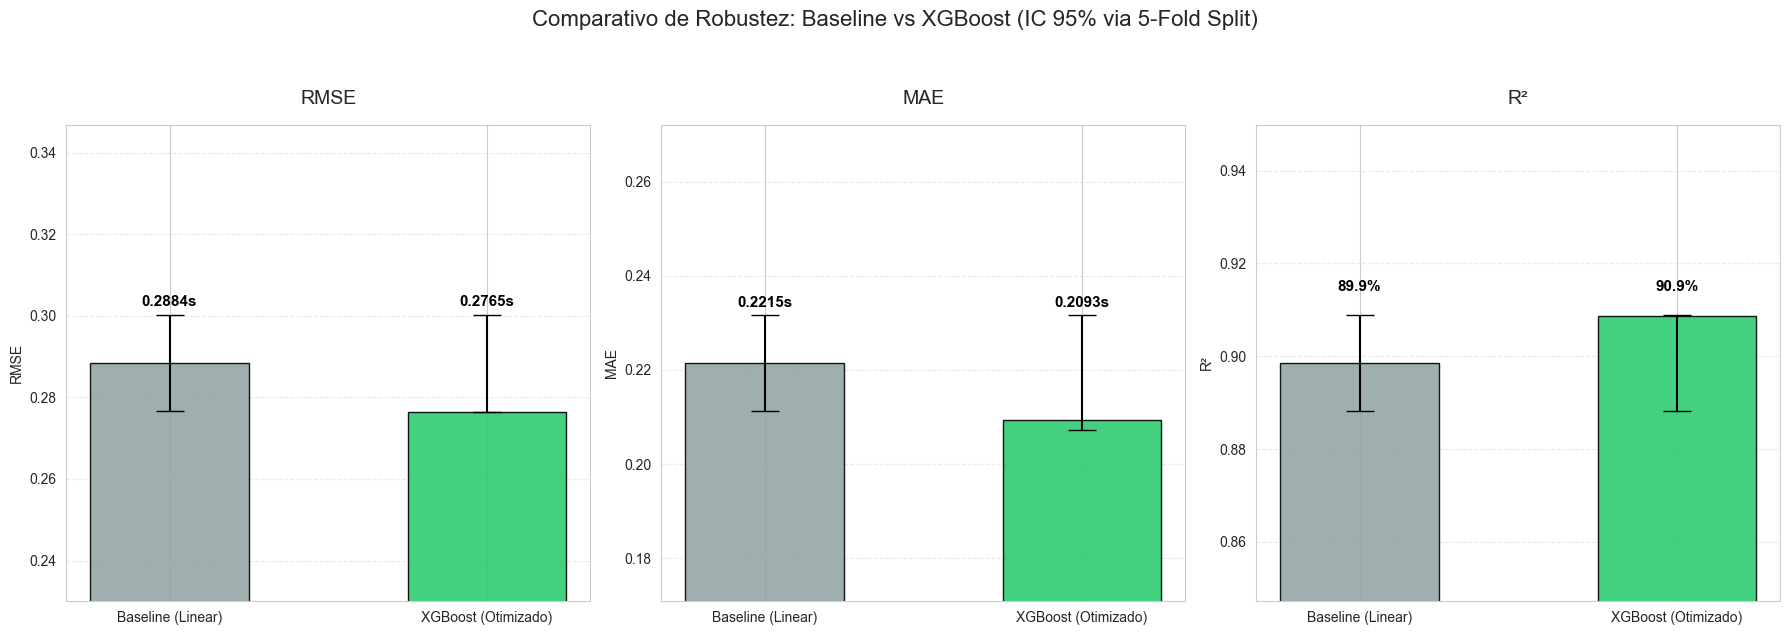

In [30]:
import matplotlib.pyplot as plt
import numpy as np


rmse_data = {
    'Baseline (Linear)': [mean_rmse_lr, lower_rmse_lr, upper_rmse_lr],
    'XGBoost (Otimizado)': [rmse_mean, rmse_l, rmse_u]
}

mae_data = {
    'Baseline (Linear)': [mean_mae_lr, lower_mae_lr, upper_mae_lr],
    'XGBoost (Otimizado)': [mae_mean, mae_l, mae_u]
}

r2_data = {
    'Baseline (Linear)': [mean_r2_lr, lower_r2_lr, upper_r2_lr],
    'XGBoost (Otimizado)': [r2_mean, r2_l, r2_u]
}

def plot_confidence_intervals(data, metric_name, ax, higher_is_better=False):
    models = list(data.keys())
    means = [data[m][0] for m in models]
    
    yerr = np.array([
        [np.abs(data[m][0] - data[m][1]), np.abs(data[m][2] - data[m][0])] for m in models
    ]).T

    colors = ['#95a5a6', '#2ecc71'] 

    bars = ax.bar(models, means, yerr=yerr, capsize=10, 
                  color=colors, alpha=0.9, width=0.5, edgecolor='black', linewidth=1)

    for i, bar in enumerate(bars):
        height = bar.get_height()
        upper_limit = data[models[i]][2]
        
        label_pos = upper_limit + (upper_limit * 0.005) 

        if metric_name == 'R²':
             label_text = f'{height:.1%}' 
        else:
             label_text = f'{height:.4f}s' 

        ax.text(bar.get_x() + bar.get_width()/2., label_pos,
                label_text, ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

    ax.set_title(f'{metric_name}', fontsize=14, pad=15)
    ax.set_ylabel(f'{metric_name}')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    
    min_val = min(data[m][1] for m in models)
    max_val = max(data[m][2] for m in models)
    margin = (max_val - min_val) * 2
    ax.set_ylim(min_val - margin, max_val + margin)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

plot_confidence_intervals(rmse_data, 'RMSE', axes[0], higher_is_better=False)
plot_confidence_intervals(mae_data, 'MAE', axes[1], higher_is_better=False)
plot_confidence_intervals(r2_data, 'R²', axes[2], higher_is_better=True)

plt.suptitle('Comparativo de Robustez: Baseline vs XGBoost (IC 95% via 5-Fold Split)', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()